<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Last amended: 13th Jan, 2024
# Click through rate prediction
#  Predict whether a mobile ad will be clicked
# Data Source:
#   https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

In case you are not executing the code, but only giving it a reading to understand it, please open it in colab to take adavantage of proper manageable collapsible, hierarchical structure of notebook.

## Cleanup
Delete all earlier saved work. Start afresh. Commented to avoid deleteion by mistake.

In [ ]:
# -0.2 WARN Will delete all earlier work

#   Delete all saved avazu data

"""
from pathlib import Path
import shutil
avazufolder = Path("C:\\avazu\\allmodels\\")

if avazufolder.exists():
    shutil.rmtree(avazufolder)
"""

## Basics
Package installations, calling libraries and creating folders to save work

In [ ]:
# 0.1 Install from pypi:
%reset
!pip install catencfamily==0.0.96  # 0.0.99 next

In [ ]:
# 0.2 Easy to format columns into tables:
#     Used pandas also

! pip install python-tabulate

ERROR: Could not find a version that satisfies the requirement python-tabulate (from versions: none)
ERROR: No matching distribution found for python-tabulate


In [1]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time


# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,f1_score,roc_auc_score,accuracy_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0.4
import xgboost as xgb
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.0.5
from tabulate import tabulate
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg', 'graph_tool', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [2]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Create folders to save our work
We save data and results so that next time, work can continue from that point onwards.

In [3]:
# 1.0.7 Our folders to save work and results:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators.
                                              # Not used. For future..
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [4]:
# 1.0.7 Our folders (alternative place):
#       You can substitute below with your
#         own alternative place (for example colab
#           VM foders such as /content/) BUT do not
#             change folder names as these are used
#              throughout the code.

avazufolder = Path("c:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators.
                                              # Not used. For future..
avazuunitvecs = avazufolder / "unitvectors"   # For unitvectors

In [5]:
# 1.0.8 Create all these folders, if not already existing:

avazufolder.mkdir(parents=True, exist_ok=True)
avazugraphs.mkdir(parents=True, exist_ok=True)
avazudata.mkdir(parents=True, exist_ok=True)
avazuestimators.mkdir(parents=True, exist_ok=True)
avazuunitvecs.mkdir(parents=True, exist_ok=True)


In [6]:
# 1.0.9 Decide program-wide random state:
#       Yes, if we discontinue in between
#       and restart from some other point
#       in the notebook, this would change.

rng= np.random.RandomState(None)

## Taking a sample of data
We take a sample of 20lakh observations (limited by RAM that we have)


In [ ]:
## 1.1 We will extract data randomly from disk using the following code:

dataPath = "c:\\avazu\\"

dtypes = {
        'C1'              : 'uint16',
        'banner_pos'      : 'uint8',
        'device_type'     : 'uint8',
        'device_conn_type': 'uint8',
        'C14'             : 'uint16',
        'C15'             : 'uint16',
        'C16'             : 'uint16',
        'C17'             : 'uint16',
        'C18'             : 'uint8',
        'C19'             : 'uint16',
        'C20'             : 'int32',
        'click'           : 'uint8'
        }

print('load train...')


# 1.2 Read a fraction of data
total_lines = 40428967   #  (40428967, 24)
read_lines =   2000000

# 1.3 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read

parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
train = pd.read_csv(
                     dataPath + "train.gz",
                     header=0,
                     skiprows=lambda i: (i >0 ) and (np.random.random() > p),
                     dtype=dtypes,
                     parse_dates=['hour'],
                     date_parser=parse_date
                    )   # Takes 2minutes

_= gc.collect()

load train...


In [ ]:
# 1.3.1
train.shape   # (2001493, 24)/(1998733, 24)/(1999324, 24)/(1999503, 24)/(2001360, 24)
train.head(3)

(1999598, 24)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10006415976094813740,0,2014-10-21,1005,0,f84e52b6,d7e2f29b,28905ebd,ecad2386,7801e8d9,...,1,0,16838,320,50,1882,3,35,-1,13
1,10006958186789044052,1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,...,1,0,18993,320,50,2161,0,35,100034,157
2,10010452321736390000,1,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15701,320,50,1722,0,35,100084,79


In [ ]:
# 1.3.2 Imbalanced data:

train['click'].value_counts()
print("\n")
train['click'].value_counts(normalize = True)  # 83%:17%

# 1.3.3
train.dtypes

0    1659222
1     340376
Name: click, dtype: int64

0    0.829778
1    0.170222
Name: click, dtype: float64

In [ ]:
# 1.3.4 Separate target, and drop id

y = train.pop("click")
_= train.pop("id")

## Prepare data for transformation
Check cat cols, column names, null values and label-encode, if neeeded

In [ ]:
# 1.3.5 Our list of columns:

print(list(train.columns))

# 1.1.6 Here is a list of all columns except 'hour'
cols = ["C1","banner_pos","site_id","site_domain","site_category",
        "app_id","app_domain","app_category","device_id","device_ip",
        "device_model", "device_type", "device_conn_type", "C14",
        "C15", "C16","C17", "C18", "C19", "C20", "C21"]

['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [ ]:
# 2.0 Check no of unique values in every column
#     Two columns, device_id and device_ip,
#     have very large no of unique values:

u = []
for i in train.columns:
  u.append([i, train[i].nunique()])

# 3.1.1
print(tabulate(u, headers = ["col name", "No of unique values"]))

col name            No of unique values
----------------  ---------------------
hour                                240
C1                                    7
banner_pos                            7
site_id                            3029
site_domain                        3512
site_category                        23
app_id                             3962
app_domain                          241
app_category                         28
device_id                        278842
device_ip                        963159
device_model                       5757
device_type                           5
device_conn_type                      4
C14                                2367
C15                                   8
C16                                   9
C17                                 424
C18                                   4
C19                                  66
C20                                 165
C21                                  60


In [ ]:
# 2.1 Rename columns as per requirement of our CatEncodersFamily class
#     Column names are not to have digits and underscores:

cols = {
        "C1" : "Cone",
        "banner_pos" : "bannerpos",
        "site_id"    :  "siteid",
        "site_domain": "sitedomain",
        "site_category" : "sitecategory",
        "app_id"        : "appid",
        "app_domain"    : "appdomain",
        "app_category"  : "appcategory",
        "device_model"  : "devicemodel",
        "device_type"   : "devicetype",
        "device_ip"     : "deviceip",
        "device_id"      : "deviceid",
        "device_conn_type" : "deviceconntype",
        "C14" : "Cfourteen",
        "C15" : "Cfifteen",
        "C16" : "Csixteen",
        "C17" : "Cseventeen",
        "C18" : "Ceighteen",
        "C19" : "Cnineteen",
        "C20" : "Ctwenty",
        "C21" : "Ctwentyone"
        }

train = train.rename( columns = cols)
train.shape  #    (2001493, 22)/(1998733, 22)/(1999324, 22)/(1999503, 22)
train.head(3)

(1999598, 22)

,hour,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,...,devicetype,deviceconntype,Cfourteen,Cfifteen,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone
0,2014-10-21,1005,0,f84e52b6,d7e2f29b,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,16838,320,50,1882,3,35,-1,13
1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,f95efa07,a99f214a,...,1,0,18993,320,50,2161,0,35,100034,157
2,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,15701,320,50,1722,0,35,100084,79


### Extract date components

In [ ]:
# 2.2 Extract date components then del 'hour' column:

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour

_=train.pop('hour')
train.head(2)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,f84e52b6,d7e2f29b,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,a8649089,...,50,1882,3,35,-1,13,10,1,21,0
1,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,f95efa07,a99f214a,ce6e6bbd,...,50,2161,0,35,100034,157,10,1,21,0


### Label Encoding cat cols
xgboost classifier will not accept columns having text data

In [ ]:
# 3.0 Some columns need label encoding for feeding
#     into xgboost classifier. xgboost classifier will
#     not accept columns with text values.

train.iloc[:, :5].head(2)   # siteid, sitedomain,sitecategory
train.iloc[:, 5:10].head(2)   # appid,appdomain,appcategory,device_id,device_ip
train.iloc[:, 10:15].head(2)  # devicemodel


,Cone,bannerpos,siteid,sitedomain,sitecategory
0,1005,0,f84e52b6,d7e2f29b,28905ebd
1,1005,0,85f751fd,c4e18dd6,50e219e0


,appid,appdomain,appcategory,deviceid,deviceip
0,ecad2386,7801e8d9,07d7df22,a99f214a,a8649089
1,0acbeaa3,45a51db4,f95efa07,a99f214a,ce6e6bbd


,devicemodel,devicetype,deviceconntype,Cfourteen,Cfifteen
0,e9b8d8d7,1,0,16838,320
1,2cd8ff6d,1,0,18993,320


In [ ]:
# 3.0.1 List of cols to label encode:

ColumnsToLabelEncode = ["siteid", "sitedomain", "appid", "appdomain",
                        "appcategory", "deviceid", "deviceip",
                        "devicemodel", 'sitecategory']


# 3.0.2 Check our list once again:

train[ColumnsToLabelEncode[:4]].head(2)
train[ColumnsToLabelEncode[4:]].head(2)


,siteid,sitedomain,appid,appdomain
0,f84e52b6,d7e2f29b,ecad2386,7801e8d9
1,85f751fd,c4e18dd6,0acbeaa3,45a51db4


,appcategory,deviceid,deviceip,devicemodel,sitecategory
0,07d7df22,a99f214a,a8649089,e9b8d8d7,28905ebd
1,f95efa07,a99f214a,ce6e6bbd,2cd8ff6d,50e219e0


In [ ]:
# 3.1 Label encode columns of train data:
#     Takes time:

dict_ = {}  # To save label encoder objects here for future use
for i in ColumnsToLabelEncode:
    le = LabelEncoder()
    _=le.fit(train[i])
    train[i] = le.transform(train[i])
    dict_[i] = le  # Store the label encoder object
    _=gc.collect()

In [ ]:
# 3.2 Check again if encoding done?

train[ColumnsToLabelEncode[:4]].head(3)
train[ColumnsToLabelEncode[4:]].head(3)

,siteid,sitedomain,appid,appdomain
0,2923,2983,3667,107
1,1575,2720,169,62
2,359,3339,3667,107


,appcategory,deviceid,deviceip,devicemodel,sitecategory
0,0,184979,633844,5242,1
1,26,184979,776935,959,5
2,0,184979,778570,3615,1


### Partition data

In [ ]:
# 4.0 Split our data

X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    random_state= rng)




# 4.0.1 Check shapes:
X_train.shape    # (1501119, 25)/(1499049, 25)/(1499493, 25)/(1499627, 25)/(1499698, 25)
X_test.shape     # (500374, 25)/(499684, 25)/(499831, 25)/(499876, 25)/(499900, 25)
y_train.shape    # (1501119,)/(1499049,)/(1499493,)/(1499627,)
y_test.shape     # (500374,)/(499684, )/(499831,)/(499876,)

(1499698, 25)

(499900, 25)

(1499698,)

(499900,)

In [ ]:
# 4.1 Check nulls. None.:

X_train.isnull().sum().sum()
X_test.isnull().sum().sum()

0

0

In [ ]:
# 4.2 Check distribution of levels in split data:

y_test.value_counts(normalize = True)  # 83%:17%
y_train.value_counts(normalize = True) # 83%:17%


0    0.829778
1    0.170222
Name: click, dtype: float64

0    0.829778
1    0.170222
Name: click, dtype: float64

## Save all data files
This is for future use. Next time we can start from here instead of executing from the beginning.

In [ ]:
# 6.0 Save the dict of LabelEncoder objects for future use:
#     We, however, do not use the saved dict:

utils.savePythonObject( dict_, "labelEnoders.pkl", avazudata)


# 6.1 Save also label encoded train data:

train.to_pickle( Path(avazudata) / "train_encoded.pkl")
y.to_pickle(Path(avazudata) / "y.pkl")


# 6.2 Also save partitioned data:

X_train.to_pickle(Path(avazudata) / "X_train.pkl")
X_test.to_pickle(Path(avazudata) / "X_test.pkl")
y_train.to_pickle(Path(avazudata) / "y_train.pkl")
y_test.to_pickle(Path(avazudata) / "y_test.pkl")


# 6.3 Finally list all files that we have got here:

list(Path(avazudata).iterdir())

Object saved to: c:\avazu\allmodels\datafiles\labelEnoders.pkl


[WindowsPath('c:/avazu/allmodels/datafiles/labelEnoders.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/train_encoded.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/X_test.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/X_train.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/y.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/y_test.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/y_train.pkl')]

## Instantiate and fit `CatEncodersFamily` class

In [ ]:
# 7.0 Which are our cat columns

# 7.1 We cosider all cat features except deviceid and deviceip
#     These two columns as we will shortly see are not important:
#     (But, were we to consider them, we have to merge some rare
#     occurring levels as has been done in the case of talkingData
#     for 'ip'):

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone']   #  exclude: ['deviceid', 'deviceip']

print(f"No of cat_cols is: {len(cat_cols)}")  # 19

# 7.2 Remaining columns are a mix of numeric and cat:

#rem_cols =  set(train.columns).difference(set(cat_cols))
#print(f"Remaining columns are: '{rem_cols}'")

rem_cols = ['day', 'hour_time', 'month', 'dayofweek', 'deviceid', 'deviceip']


# 7.3 As number of cat_cols are quite large
#     Keep interacting columns as null

interactingCatCols = []


In [ ]:
# 8.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(cMeasures=  [ 1,1,1,0,None,0,0],
                        modelsPath = avazugraphs , # Folder to store graph files
                                                    # Will be created if it does not exist
                        pathToStoreProgress  = avazufolder , # Progress recorded in *.csv files
                        saveGraph = True,   # Save all generated *.gml files
                        cutoff = 4  # transform those cat features having levels greater than 4
                       )

# 8.0.1 Fit it on X_train:

gc.collect()
start = time.time()
ct.fit(X_train, cat_cols, interactingCatCols)
end = time.time()
print((end-start)/60)    # 73 minutes

0

Record set no is 1  
Set of records is:  [('Cone', 'bannerpos', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'siteid', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'sitedomain', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'sitecategory', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'appid', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'appdomain', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'appcategory', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'devicemodel', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'devicetype', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'deviceconntype', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Cfourteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Cfifteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Csixteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Cseventeen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Ceighteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Cnineteen', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Ctwenty', [1, 1, 1, 0, None, 0, 0]), ('Cone', 'Ctwentyone', [1, 1, 1, 0, None, 0, 0]), ('bannerpos', 'Cone', [1, 1, 1, 0, None, 0, 0]), ('bannerpos', 'siteid'

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], cutoff=4,
                  mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

72.78444997072219


### Save `CatEncodersFamily` object
Maybe for later use

In [ ]:
# 8.1 Save the fitted class object for later use:

utils.savePythonObject(ct, "transformer.pkl", avazudata)

# 8.1.1 We can also delete existing class object

#del ct

Object saved to: c:\avazu\allmodels\datafiles\transformer.pkl


In [ ]:
# 8.1.2 And read back saved class object:

ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], cutoff=4,
                  mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

## Data transformation
Transform `(X_train, X_test)` to `(train_trans, test_trans)`, AND then to `(X_train_trans, X_test_trans)`. `(X_train_trans, X_test_trans)` have only numeric columns ie *transformed cols + date-time columns* BUT no cat_cols.

In [ ]:
# 8.2 Transform X_train now:

_ = gc.collect()
start = time.time()
train_trans = ct.transform(X_train[cat_cols])
end = time.time()
print((end -start)/60)  # 290min on a very slow machine
_= gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  918
====Sending model loading progress to file: c:\avazu\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 9046.178336 MB
Mem usage after dtype transformation is: 4571.079504 MB
290.22881970802945


In [ ]:
# 8.2 Transform X_test data:

start = time.time()
test_trans = ct.transform(X_test[cat_cols])
end = time.time()
print((end -start)/60)  # 29 min on a very slow machine
gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  918
====Sending model loading progress to file: c:\avazu\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 3015.3968 MB
Mem usage after dtype transformation is: 1523.6952 MB
29.28777941862742


0

In [ ]:
# 8.3 Check shapes:

train_trans.shape      # (1499493, 591)/(1499627, 603)/(1499698, 765)
test_trans.shape       #  (499831, 591)/(499876, 603)/(499900, 765)

(1499698, 765)

(499900, 765)

### Save transformed data

In [ ]:
# 9.0 Save transformed data to avazufolder:

gc.collect()
train_trans.to_pickle(Path(avazudata) / "train_trans.pkl")
test_trans.to_pickle(Path(avazudata) / "test_trans.pkl")

0

### Read transformed data
Read back all saved/processed data

In [7]:
# 9.1 Our data folders. Just to recall:

avazufolder = Path("c:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"  # For *.pkl files
avazuestimators = avazufolder / "estimators"  # For fitted estimators. Not used
avazuunitvecs = avazufolder / "unitvectors"   # For unitvectors

In [8]:
# 9.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test
#       train_trans and test_trans are already reindexed

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check:

train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
train_trans.shape   # (1501119, 599)/(1499049, 595)/(2249004, 779)/(1499493, 591)/(1499627, 603)/(1499698, 765)
y_train.shape       # (1501119,),(1499049,),(1499493,)(1499627,)(1499698,)
test_trans.shape    # (500374, 599)/(499684, 595)/(749668, 779),(499831, 591),(499876, 603)/(499900, 765)
y_test.shape        # (500374,)/(499684,),(499831,),(499876, )(499900,)

# 9.2.4
rem_cols = ['day', 'hour_time', 'month', 'dayofweek', 'deviceid', 'deviceip'] # 4+2 cols
_=gc.collect()

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1102,1665,3,3667,107,0,1203,1,...,0.151011,0.271186,0.032768,0.009207,0.203390,0.068588,0.010675,0.915254,0.142844,0.019491
1,1005,0,359,3339,1,3667,107,0,563,1,...,-0.034182,0.694915,0.141788,0.016860,0.457627,0.170485,0.020274,0.915254,0.143742,0.019360


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1575,2720,5,3277,6,4,4606,1,...,0.118601,0.559322,0.081644,0.015594,0.186441,0.057565,0.011602,0.915254,0.142844,0.019491
1,1005,0,359,3339,1,3667,107,0,847,1,...,0.113822,0.711864,0.142679,0.017328,0.491525,0.173426,0.022475,0.949153,0.144855,0.020258


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1102,1665,3,3667,107,0,184979,384356,...,250,2162,2,39,100101,33,10,3,30,15
1,1005,0,359,3339,1,3667,107,0,184979,51728,...,50,1722,0,35,-1,79,10,1,21,6


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1575,2720,5,3277,6,4,184979,33570,...,50,122,3,1327,-1,15,10,3,23,15
1,1005,0,359,3339,1,3667,107,0,184979,914979,...,50,2616,0,35,-1,51,10,3,30,13


(1499698, 765)

(1499698,)

(499900, 765)

(499900,)

In [9]:
# 9.3 Our cat cols:

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone'] # 19 cols

# 9.3.1 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'deviceid', 'deviceip']  # 4+2 cols

# 9.3.2 Includes all 19 cat_cols:

train_trans.columns[:20]

Index(['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid',
       'appdomain', 'appcategory', 'devicemodel', 'devicetype',
       'deviceconntype', 'Cfourteen', 'Cfifteen', 'Csixteen', 'Cseventeen',
       'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone',
       'deg_Cone_ck_bannerpos'],
      dtype='object')

In [10]:
# 9.4 Concat first four rem_cols with transformed data:

# 9.4.1 Columns to be considered. Ignore initial cat_cols:

transcols = train_trans.columns[len(cat_cols):]

# 9.4.2 Now horizontally concat but only Ist four rem_cols
#       (ie exclude deviceid and deviceip):

X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[transcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[transcols] ], axis = 1)

# 9.4.3 Check
X_train_trans.shape  # (1501119, 586)/(1499049, 582)/(2250941, 586)/(1499493, 576)/
                     # (1499627, 588)/(1499698, 750)
X_test_trans.shape   # (500374, 586)/(499684, 582)/(750314, 586)/(499831, 576)/(499876, 588)
                     # (499876, 588) 603-19 +4 = 588/(499900, 750)

(1499698, 750)

(499900, 750)

## XGboost modeling for original and transformed data
><font color='red'><b>A.</b></font> xgboost with original data: cat_cols + time cols<br>
><font color='red'><b>B.</b></font> xgboost model with only transformed data + time data AND no cat_cols<br>
><font color='red'><b>C.</b></font> XGboost modeling with orig data, cat_cols + time, BUT without deviceid and deviceip<br>
><font color='red'><b>D.</b></font> Xgboost model with only transformed data + time data BUT with impt features<br>

>> In all four cases F1 score is around 0.16, recall is 0.09
>> AUC hovers around 0.75. AUCs of transformed data and of transformed data with impt features are a shade better than the two; this is the general trend in our repeated experiments with this data.

>>Results are:<br>
  
| Data | Best AUC | F1 score |  Recall |   
| --- | --- | --- | -- |
| Original | 0.75006940 | 0.15 | 0.09 |  
| Original minus deviceid/deviceip | 0.749759663 | 0.16 | 0.09 |  
| Transformed |  <b>0.7529464064</b> | 0.16 | 0 |
| Transformed with impt features | 0.752946406 | 0.16 | 0.09 |

### <font color='red'><b>A.</b></font> xgboost with original data: cat_cols + time cols

In [ ]:
# 10.0 Prepare xgboost model--Original data

model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']
          )


In [ ]:
# 10.0.1 Save the model object:

utils.savePythonObject(model_orig, "model_orig.pkl", avazudata )

Object saved to: c:\avazu\allmodels\datafiles\model_orig.pkl


In [11]:
# 10.0.2 Restore model object:

model_orig = utils.restorePythonObject("model_orig.pkl", avazudata )

In [ ]:
# 10.1 Best Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  #  0.75073109205036
                                                                #
print("===========")  # 0.7501188549887546 / 0.74978341087298
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 156/135


'Best auc from orig train/test data: 0.7500694075749718'

'Best iteration from orig train/test data: 135'

### <font color='red'><b>B.</b></font> xgboost model with only transformed data + time data
Original cat columns are not present

In [ ]:
# 10.2 Prepare xgboost model--Transformed data
#      Excluded: cat_cols, deviceid & deviceip
#      Included: time columns

model_trans = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans
test_X = X_test_trans
ytrain = y_train
ytest = y_test


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']
               )

In [ ]:
# 10.2.1 Save model object:

utils.savePythonObject(model_trans, "model_trans.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_trans.pkl


In [12]:
# 10.2.2 Restore model object:

model_trans = utils.restorePythonObject("model_trans.pkl", avazudata)

In [ ]:
# 10.3 Best score"

f"Best auc from transformed train/test data: {model_trans.best_score}"  # 0.7528(15L); 0.7538(20L); 0.7531621285335741(20L)
                                                                        # 0.7525667626/0.7529464064396
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 82(15L) 117(20L);70(20L)/87(20L)/92

'Best auc from transformed train/test data: 0.7529464064396215'

'Best iteration from transformed train/test data: 92'

In [ ]:
# 10.4.0
Xtr = X_train.copy()
Xte = X_test.copy()
_=Xtr.pop('deviceid')
_=Xtr.pop('deviceip')
_=Xte.pop('deviceip')
_=Xte.pop('deviceid')

### <font color='red'><b>C.</b></font> XGboost modeling with orig data, cat_cols + time, BUT without deviceid and deviceip

In [ ]:
# 10.4.0.1 Prepare xgboost model--Original data
#          But without deviceid and deviceip


model_orig_noip = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   Xtr
test_X = Xte
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig_noip.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


In [ ]:
# 10.4.1 Save and restore:

utils.savePythonObject(model_orig_noip, "model_orig_noip.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_orig_noip.pkl


In [13]:
# 10.4.2 REstore model:
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

In [14]:
# 10.4.3 Best score
#??????

f"Best auc from orig data minus deviceid/deviceip: {model_orig_noip.best_score}"  # 0.7528(15L); 0.7538(20L);  0.7506422630703(20L)
                                                                            # 0.75005234664/0.74975966300514
print("===========")
f"Best iteration:: {model_orig_noip.best_iteration}"  # 82(15L) 117(20L);136(20L)/144/141

'Best auc from orig data minus deviceid/deviceip: 0.7497596630051407'

'Best iteration:: 141'

### Classification reports
Three cases

In [ ]:
# 10.5 Original data:

pred = model_orig.predict(X_test)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.59      0.09      0.15     85094

    accuracy                           0.83    499900
   macro avg       0.71      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.83    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.83      0.78    500374

"""

In [ ]:
# 10.6 Original data without deviceid and deviceip

pred = model_orig_noip.predict(Xte)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.58      0.09      0.16     85094

    accuracy                           0.83    499900
   macro avg       0.71      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



In [ ]:
# 10.7 Transformed data:

pred = model_trans.predict(X_test_trans)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.59      0.09      0.16     85094

    accuracy                           0.83    499900
   macro avg       0.71      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



In [ ]:
"""
 precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


"""

In [ ]:
# 10.8 No longer needed
del Xtr
del Xte
_=gc.collect()

### <font color='red'><b>D.</b></font> xgboost model with only important features of transformed data   
AUC is about the same as that for transformed data.

#### Get **Feature** importance
Know feature importance of transformed data

In [ ]:
# 11.0 Get feature importance:
# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 414;405;411
print("\n")
len(fe_0)   # 172;177;177
fe[:5]  # Show impt oftop-five cols

Order of feature importance is by 'gain'


419

331

,imp
pr_Ctwentyone_ck_devicemodel,0.420083
deg_Cseventeen_ck_Csixteen,0.070271
deg_Cseventeen_ck_Ceighteen,0.025349
eig_Ctwentyone_ck_devicemodel,0.018965
pr_Cnineteen_ck_Ctwenty,0.013331


In [ ]:
# 11.0.1
utils.savePythonObject(fe_1,"fe_1.pkl", avazuestimators)

Object saved to: c:\avazu\allmodels\estimators\fe_1.pkl


In [15]:
# 11.0.2
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)
len(fe_1)

419

#### Modeling now

In [ ]:
# 11.1 Prepare xgboost model--Transformed but now with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 15,
                                       subsample = 0.8,
                                       random_state = rng,
                                     )


tr_X =   X_train_trans[fe_1]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1]
ytrain = y_train
ytest = y_test


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']
                    )

In [ ]:
# 11.1.1 Save model object:
utils.savePythonObject(model_trans_impt, "model_trans_impt.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_trans_impt.pkl


In [16]:
# 11.1.2 Restore model object:

model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", avazudata)

#### Classification reports
Classification report of model with transformed data having impt features

In [ ]:
# 11.2 Classification report of transformed data but with impt features:

model_trans.best_score    # 0.753373650(40L)/0.7525667626318204/0.7529464064396215
pred = model_trans_impt.predict(test_X)
print(classification_report(ytest, pred))

0.7529464064396215

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.59      0.09      0.16     85094

    accuracy                           0.83    499900
   macro avg       0.72      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


                   precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.60      0.09      0.15     84806

    accuracy                           0.84    499684
   macro avg       0.72      0.54      0.53    499684
weighted avg       0.80      0.84      0.78    499684



"""

## Learning curves
LEarning curves of all the four xgboost models, ie
> Model with original data<br>
>Model with original data but without deviceid and deviceip<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

As the plots show:  
- Learning plots with transformed data show AUC which is shade better than that with original data<br>
- Learning plots of original data with and without deviceid and deviceip are abouth the same


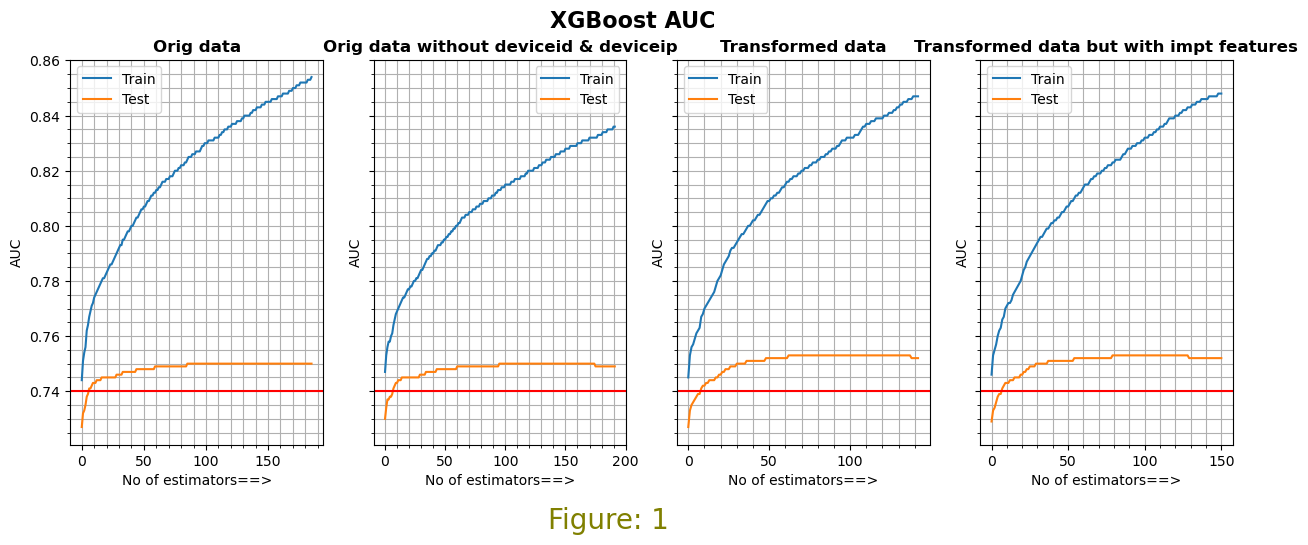

<Figure size 640x480 with 0 Axes>

In [36]:
# 12.0 Learning curves of all the three models

plt.style.use('default')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(), model_orig_noip.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["Orig data", 'Orig data without deviceid & deviceip', 'Transformed data', 'Transformed data but with impt features']
_=fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 16)

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    _=ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1.5, label='Train');
    _=ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1.5, label='Test');
    _=ax[i].legend();
    _=ax[i].grid(visible = True, which = 'both');
    _=ax[i].minorticks_on();
    _=ax[i].set_ylabel('AUC');
    _=ax[i].set_xlabel('No of estimators==>');
    _=ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    _=ax[i].axhline(y=0.74, color='r', linestyle='-')

# This needs to be adjusted    
txt="Figure: 1"
_=plt.text(-250, 0.69, txt, ha='center', fontsize = 20, color = "olive")

_=plt.show();
_=plt.tight_layout()



## PCAs of Transformed data


### Impute data

In [ ]:
# 13.0 Check if any nulls in data
#       If so, we would impute using SimpleImputer:

X_train_trans.isnull().sum().sum()  # 0
X_test_trans.isnull().sum().sum()   # 63060/65406/65932

X_train_trans.shape  # (1499627, 588)/(1499698, 750)
X_test_trans.shape   # (499876, 588)/(499900, 750)

0

65932

(1499698, 750)

(499900, 750)

In [ ]:
# 13.1 Impute as test data has null values:
#      First reduce memory requirements:
#      (We had to do it as our machine had 16gb RAM)

X_train_trans_imputed = X_train_trans.astype('float16')
X_test_trans_imputed  = X_test_trans.astype('float16')

In [ ]:
# 13.1 Impute as test data has null values:

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
X_train_trans_imputed[:] = si.fit_transform(X_train_trans_imputed)
X_test_trans_imputed[:] = si.transform(X_test_trans_imputed)
end = time.time()
print("Done: ", (end-start)/60)  # 2.79 min

Imputing....
Done:  2.7974180897076923


In [ ]:
# 13.1.1 Check for nulls again:

X_train_trans_imputed.isnull().sum().sum()  # 0
X_test_trans_imputed.isnull().sum().sum()   # 0

0

0

#### Save imputed data

In [ ]:
# 13.2 Save imputed data for later experiments:

X_train_trans_imputed.to_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed.to_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

# 13.2.0 Datashapes:

X_train_trans_imputed.shape  # (1501119, 586)/(1499049, 582)/(1499627, 588)/(1499698, 750)
X_test_trans_imputed.shape   # (500374, 586)/(499684, 582)/(499876, 588)/(499900, 750)

(1499698, 750)

(499900, 750)

#### Read imputed data

In [ ]:
# 13.2.1 Read back saved imputed data:

X_train_trans_imputed = pd.read_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

# 13.2.2 Check
X_train_trans_imputed.shape  # (1501119, 586)/(1499493, 576)/(1499627, 588)
X_test_trans_imputed.shape   # (500374, 586)/(499831, 576)/(499876, 588)

(1499698, 750)

(499900, 750)

### Perform 95% PCA

In [ ]:
# 13.2.3
ss = StandardScaler()
X_train_trans_imputed[:] = ss.fit_transform(X_train_trans_imputed)
X_test_trans_imputed[:] = ss.transform(X_test_trans_imputed)

In [ ]:
# 13.3 PCA with transformed train data.
#      Note that n_components = 0.95

gc.collect()
pca = PCA(n_components= 0.95,
          whiten= True,
          random_state = rng)

pca_train = pca.fit_transform(X_train_trans_imputed)
gc.collect()
pca_test  = pca.transform(X_test_trans_imputed)

# 13.3.1 Check data shapes:
pca_train.shape  # (1501119, 97)/(1499493, 96)/(1499627, 95)/(1499698, 101)
pca_test.shape   # (500374, 97)/(499831, 96)/(499876, 95)/(499900, 101)

0

0

(1499698, 101)

(499900, 101)

In [ ]:
# 13.4 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test =  pd.DataFrame(pca_test,  columns = colnames)

# 13.4.1 Dataframe shapes:

pca_train.shape  # (1501119, 97)/(1499493, 96)/1499627, 95)/(1499698, 101)
pca_test.shape   # (500374, 97)/(499831, 96)/(499876, 95)/(499900, 101)

(1499698, 101)

(499900, 101)

### Plotting PCA
Plotting Ist two componenets of PCA provides insights into data structure. This data clearly has two clusters.

In [38]:
# 13.5 Take a stratified sample for plotting:
#      Just 5000 samples:

_, pca_tr, _,pca_y  = train_test_split(pca_train, y_train,
                                       test_size = 5000,
                                       stratify = y_train
                                      )

# 13.5.1 Our data for plotting:
pca_tr.shape  # (5000, 97)/(5000, 95)/(5000, 101)
pca_y.shape   # (5000,)

(5000, 101)

(5000,)

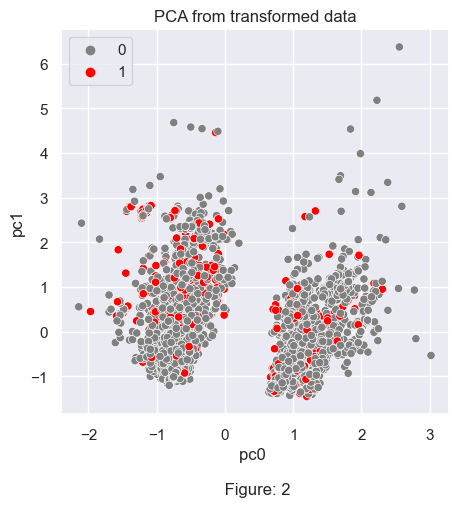

In [54]:
# 13.6 2D PCA plot from first two principal components:
#      Two clusters are evident:

fig = plt.figure(figsize = (5,5));
_=fig.add_subplot(1,1,1);
sns.set_theme() ; # Set default theme
_=sns.scatterplot(data = pca_tr,
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA from transformed data');

   
_=plt.xlabel("pc0 \n\n Figure: 2")


### Save and Read back 95% PCA data

In [ ]:
# 14.0 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazudata) / "pca_train.pkl")
pca_test.to_pickle(Path(avazudata) / "pca_test.pkl")

In [37]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazudata) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazudata) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc91,pc92,pc93,pc94,pc95,pc96,pc97,pc98,pc99,pc100
0,-1.102130,2.762019,-1.932318,-1.978797,-1.226678,1.200556,-0.850126,-1.719669,0.158196,1.284829,...,0.085401,0.069769,0.412169,-0.243730,0.223895,-0.966110,0.185412,-1.574175,-0.665990,-0.181747
1,-0.747602,-0.940209,0.079358,0.137828,0.050569,0.288186,-0.198276,-0.297121,-0.295114,0.593067,...,-0.093622,0.434330,0.703078,-1.005803,0.279632,-0.065496,-0.646179,0.278885,0.461319,0.685997
2,0.801823,-0.601027,0.178976,-1.134097,-1.004995,-0.117256,0.411918,0.756779,-0.198062,-0.390146,...,-0.459665,0.249034,-0.351790,0.015610,0.339669,-0.485977,-0.447732,-0.344832,-0.184965,0.246737


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc91,pc92,pc93,pc94,pc95,pc96,pc97,pc98,pc99,pc100
0,1.416328,0.065361,-1.036184,-0.764585,0.316942,-1.238066,-1.406431,0.465184,-0.517939,0.274045,...,-0.155122,-0.080795,-0.104881,1.019546,-0.765314,1.322599,-0.589022,0.030279,0.420456,-0.298090
1,-0.822676,0.908657,-0.652014,-0.780860,-0.874015,-0.104280,0.554407,0.314008,-0.932325,0.465668,...,0.155080,0.083235,-0.570233,-0.097183,0.126548,-0.021147,-0.305196,-0.486546,-0.130737,-0.325376
2,1.213804,-1.029678,-0.201747,-0.653222,-0.776785,0.094668,-0.746524,0.277588,-0.438296,-0.248531,...,0.393232,-0.182822,-0.722722,0.546758,1.226319,-0.018726,-0.124733,-0.101862,0.383483,0.220929


### xgboost modeling with all the PCA components


In [ ]:
# 15.0 Prepare xgboost model--PCA data

# 15.0.1 We use class weights also:
#        Actually there is no benefit of class weights:

class_weights = {0: 1, 1: 10}
model_pca = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 15,
                           subsample = 0.8,
                           class_weight = class_weights,
                           random_state = rng,
                           )


tr_X =   pca_train
test_X = pca_test
ytrain = y_train
ytest = y_test


model_pca.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']
                    )

In [ ]:
# 15.0.2 Save model object:

utils.savePythonObject(model_pca, "model_pca.pkl", avazudata)


Object saved to: c:\avazu\allmodels\datafiles\model_pca.pkl


In [51]:
# 15.0.3 Restore model object:

model_pca = utils.restorePythonObject("model_pca.pkl", avazudata)

In [ ]:
# 15.1 Best Scores:

model_pca.best_score     # 0.7377374624019014
model_pca.best_iteration # 80

0.7377374624019014

80

#### Classification report
xgboost modeling with PCA data

In [ ]:
# 15.2 Classification report of model with PCA data:

pred = model_pca.predict(test_X)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.57      0.08      0.14     85094

    accuracy                           0.83    499900
   macro avg       0.70      0.53      0.52    499900
weighted avg       0.79      0.83      0.78    499900



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.57      0.08      0.14     85094

    accuracy                           0.83    499900
   macro avg       0.70      0.53      0.52    499900
weighted avg       0.79      0.83      0.78    499900



                precision    recall  f1-score   support

           0       0.84      0.99      0.91    352805
           1       0.57      0.08      0.14     72357

    accuracy                           0.83    425162
   macro avg       0.71      0.53      0.52    425162
weighted avg       0.79      0.83      0.78    425162

               precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.57      0.08      0.14     84806

    accuracy                           0.83    499684
   macro avg       0.70      0.53      0.52    499684
weighted avg       0.79      0.83      0.78    499684



"""

#### Learning curve
xgboost modeling with PCA data

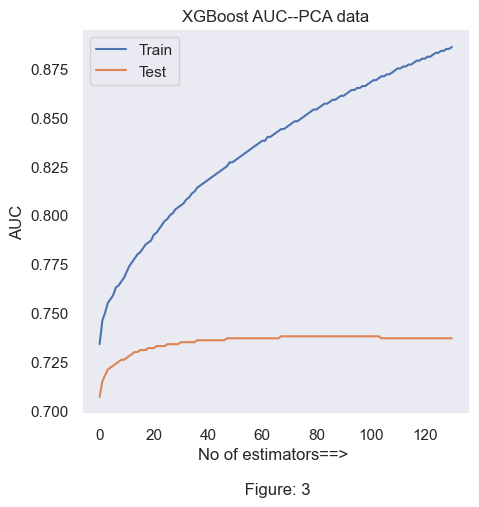

In [53]:
# 15.3 Learning curve of xgboost based on pca data:
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,1, figsize = (5,5));

results = model_pca.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs);
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax.legend();
ax.grid();
ax.set_ylabel('AUC');
ax.set_xlabel('No of estimators==> \n\n Figure: 3')
ax.set_title("XGBoost AUC--PCA data");


_=plt.show();
_=plt.tight_layout()



## Balanacing PCA train data with `imblearn` library


We use imblearn library
>Balance (or rather undersample) with [`EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)<br>
>Balance with [`SMOTEENN`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)<br>

The former removes majority samples along the decision boundary and hence undersamples majority data. The next one performs SMOTE followed by cleaning along the decision boundary.<br>
A simple explanation of how the techniques work is [here](https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50)

Steps followed here are:<br>
>a. Undersample or oversample+undersample PCA data  
>b. Plot fist two PCs in each of the two cases  
>c. Perform XGBoost modeling in each of the two cases  

Results are as follows:




| Data | Best AUC | F1 score |  Recall |   
| --- | --- | --- | -- |
| Original data | <b>0.75006940</b> | 0.15 | 0.09 |  
| PCA data | 0.737737462 | 0.14 | 0.08 |  
| PCA followed by `EditedNearestNeighbours` |  0.7387503785918 | 0.37 | 0.37 |
| PCA followed by `SMOTEENN` | 0.730573852 | <b>0.40</b> | <b>0.72</b> |

In [58]:
# 16.0 Call imblearn library:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

## Using `EditedNearestNeighbours`
Undersamples majority class near decision boundary

In [59]:
# 16.1 Undersample PCA train data:

start = time.time()
undersample = EditedNearestNeighbours()
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 30min

# 16.1.1 Data shape
X_res.shape  #  (1075328, 97)/(1091067, 96)/(1089900, 95)/(1091041, 101)
y_res.shape  #  (1075328,)/(1074577, )/(1091067,)/(1089900, )/(1091041,)

30.160246884822847


(1091041, 101)

(1091041,)

In [60]:
# 16.1.1 Save X_res and y_res

X_res.to_pickle(Path(avazudata) / "X_res.pkl")
y_res.to_pickle(Path(avazudata) / "y_res.pkl")

In [61]:
# 16.1.2 Restore 
X_res = pd.read_pickle(Path(avazudata) / "X_res.pkl" )
y_res = pd.read_pickle(Path(avazudata) / "y_res.pkl" )

### Plot of Ist two components of cleanedup data
Even here, two clusters are evident.

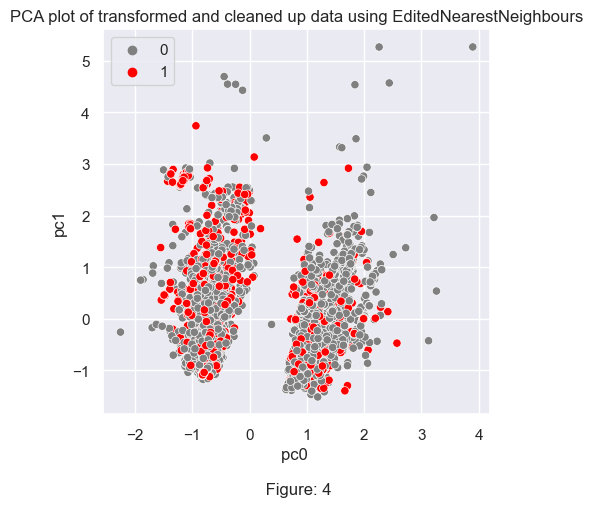

In [64]:
# 17.0 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res,
                                       y_res,
                                       test_size = 5000,
                                       stratify = y_res
                                       )

fig = plt.figure(figsize = (5,5));
_=fig.add_subplot(1,1,1);
_=sns.set_theme() ;
_=sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA plot of transformed and cleaned up data using EditedNearestNeighbours') ;

_=plt.xlabel("pc0 \n\n Figure: 4")

### xgboost modeling with undersampled data

In [ ]:
# 17.3 xgboost Modeling with undersampled data

model_en = xgb.XGBClassifier( n_estimators= 650 , #Needs to be reduced
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 8,
                               subsample = 0.9,
                               random_state = rng,
                           )


tr_X =   X_res
test_X = pca_test
ytrain = y_res
ytest =  y_test


model_en.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )



In [ ]:
# 17.3.1:
utils.savePythonObject(model_en, "model_en.pkl", avazudata)

44

Object saved to: c:\avazu\allmodels\datafiles\model_en.pkl


In [73]:
# 17.3.2
model_en = utils.restorePythonObject("model_en.pkl", avazudata)

In [ ]:
# 17.4 Scores:

model_en.best_score     # 0.7387503785918077
model_en.best_iteration # 579

0.7387503785918077

579

### Classification report
After balancing data with `EditedNearestNeighbours` class

In [ ]:
# 17.5 Classification report xgboost model with undersampled PCA data:

pred = model_en.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87    414806
           1       0.37      0.37      0.37     85094

    accuracy                           0.78    499900
   macro avg       0.62      0.62      0.62    499900
weighted avg       0.78      0.78      0.78    499900



In [ ]:
"""

                precision    recall  f1-score   support

           0       0.87      0.87      0.87    414806
           1       0.37      0.37      0.37     85094

    accuracy                           0.78    499900
   macro avg       0.62      0.62      0.62    499900
weighted avg       0.78      0.78      0.78    499900


                precision    recall  f1-score   support

           0       0.87      0.86      0.87    415242
           1       0.36      0.39      0.38     85132

    accuracy                           0.78    500374
   macro avg       0.62      0.62      0.62    500374
weighted avg       0.79      0.78      0.78    500374

iter2
=====
               precision    recall  f1-score   support

           0       0.87      0.86      0.87    414878
           1       0.36      0.38      0.37     84806

    accuracy                           0.78    499684
   macro avg       0.62      0.62      0.62    499684
weighted avg       0.79      0.78      0.78    499684

"""

## Using `SMOTEENN`
For balancing PCA data and then cleaning

In [65]:
# 18.0 Instantiate SMOTEEN and use it on pca_train:

start= time.time()
sm = SMOTEENN(random_state=rng, n_jobs = -1)
X_res_sm, y_res_sm = sm.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 100m (20L)

39569

100.93852171500524


In [66]:
# 18.0.1 Save X_res and y_res

X_res_sm.to_pickle(Path(avazudata) / "X_res_sm.pkl")
y_res_sm.to_pickle(Path(avazudata) / "y_res_sm.pkl")

In [67]:
# 18.0.2 Restore 

X_res_sm = pd.read_pickle(Path(avazudata) / "X_res_sm.pkl" )
y_res_sm = pd.read_pickle(Path(avazudata) / "y_res_sm.pkl" )

In [68]:
# 18.0.3 Data shape after SMOTEENN

X_res_sm.shape  # (1688427, 97)/(1558844, 96)/(1557978, 95)/(1558408, 95)/(1553492, 101)
y_res_sm.shape  # (1688427,),(1558844,)/(1557978,)/(1558408,)/(1553492,)

(1555447, 101)

(1555447,)

In [ ]:
# 18.0.4:

y_res_sm.value_counts()
y_res_sm.value_counts(normalize = True)  # 51%:48%

1    801435
0    752057
Name: click, dtype: int64

1    0.515893
0    0.484107
Name: click, dtype: float64

### Plot of Ist two components of oversampled/cleanedup data
Two clusters are eveident here

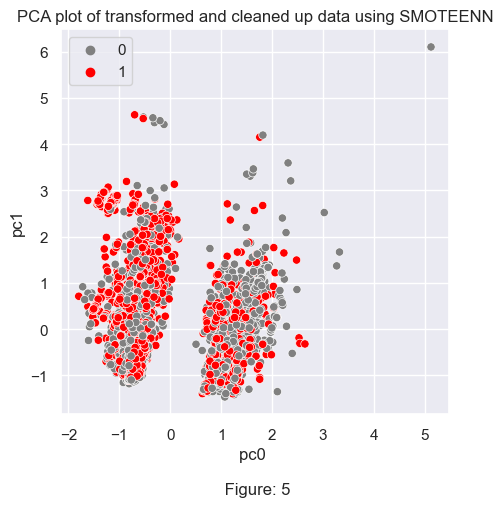

In [70]:
# 18.0.5 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:
# StackOverflow: https://stackoverflow.com/a/51486361/3282777

_, pca_tr, _,pca_y  = train_test_split(X_res_sm, y_res_sm, test_size = 5000, stratify = y_res_sm)

fig = plt.figure(figsize = (5,5));
_=fig.add_subplot(1,1,1);
_=sns.set_theme() ;
_=sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA plot of transformed and cleaned up data using SMOTEENN') ;


_=plt.xlabel("pc0 \n\n Figure: 5")

### xgboost modeling with balanced data (SMOTEENN)

In [ ]:
# 19.0 Modeling with smoteenn data

model_sm = xgb.XGBClassifier( n_estimators= 650,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res_sm
test_X = pca_test
ytrain = y_res_sm
ytest =  y_test


model_sm.fit(tr_X, ytrain.values,
                early_stopping_rounds = 100,
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']
                )



In [ ]:
# 19.0.1

utils.savePythonObject(model_sm, "model_sm.pkl", avazudata)

3763

Object saved to: c:\avazu\allmodels\datafiles\model_sm.pkl


In [72]:
# 19.0.2
model_sm = utils.restorePythonObject("model_sm.pkl", avazudata)

In [ ]:
# 19.1 score
model_sm.best_score   # 0.7320805711/0.73260329129(20L)/0.7305378582/0.730988385236/0.7305738525325511
model_sm.best_iteration  # 230/222/308/213

0.7305738525325511

213

#### Classification report
After balancing with `SMOTEENN` class

In [ ]:
# 19.2
pred = model_sm.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74    414806
           1       0.28      0.72      0.40     85094

    accuracy                           0.64    499900
   macro avg       0.60      0.67      0.57    499900
weighted avg       0.81      0.64      0.68    499900



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.91      0.62      0.74    414806
           1       0.28      0.72      0.40     85094

    accuracy                           0.64    499900
   macro avg       0.60      0.67      0.57    499900
weighted avg       0.81      0.64      0.68    499900


               precision    recall  f1-score   support

           0       0.93      0.54      0.69    415242
           1       0.26      0.79      0.40     85132

    accuracy                           0.59    500374
   macro avg       0.60      0.67      0.54    500374
weighted avg       0.82      0.59      0.64    500374


               precision    recall  f1-score   support

           0       0.93      0.55      0.69    414878
           1       0.26      0.79      0.40     84806

    accuracy                           0.59    499684
   macro avg       0.60      0.67      0.54    499684
weighted avg       0.81      0.59      0.64    499684

"""

## Learning plots
xgboost modeling with the two class balancing techniques

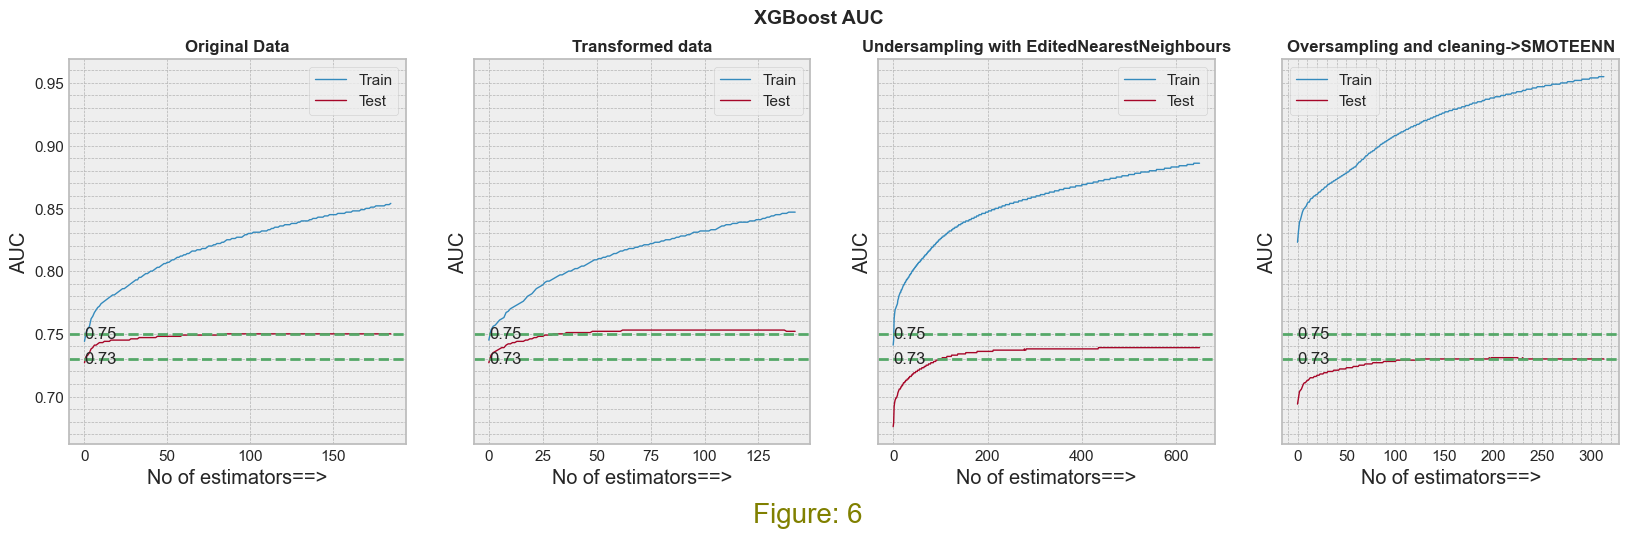

In [89]:
# 19.3 Learning curves: xgboost modeling

plt.style.use('bmh')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result()]
title = ["Original Data", "Transformed data", "Undersampling with EditedNearestNeighbours", 'Oversampling and cleaning->SMOTEENN']
fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 14)
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y=0.75, color='g', linestyle='--', label='p=0.05')
    ax[i].axhline(y=0.73, color='g', linestyle='--')
    ax[i].text(0, 0.75, '0.75', ha='left', va='center')
    ax[i].text(0, 0.73, '0.73', ha='left', va='center')



# This needs to be adjusted    
txt="Figure: 6"
_=plt.text(-500, 0.60, txt, ha='center', fontsize = 20, color = "olive")

plt.show();

## Distribution of transformed features:
We make three plots:
>a. Proportion of columns as per centrality measure   
>b. Proportion of impt features as per centrality measures  
>c. Among important columns, sum up impt scores by centrality measures and plot as a percentage


This is how the features related to different centrality measures are distributed

### Proportion of columns by centrality measure:

eigenvector          0.410188
degree               0.294906
pagerank             0.294906
clusteringcoeff      0.000000
betweenness          0.000000
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

Text(0.5, 0, '\n\n Figure: 7')

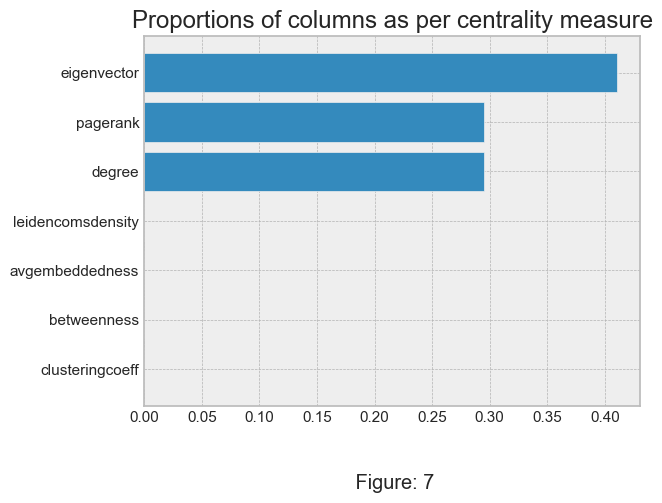

In [96]:
# 20.0 Our list of columns

colList = X_train_trans.columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")
plt.xlabel("\n\n Figure: 7")


### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

Order of feature importance is by 'gain'


'Columns whose impt is >0: 411'

'Columns whose impt is 0: 177'

Text(0.5, 0, '\n\n Figure: 8')

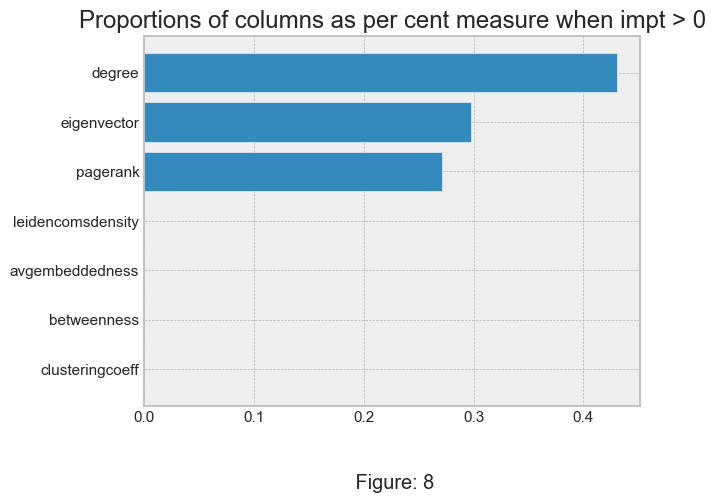

In [97]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")
plt.xlabel("\n\n Figure: 8")

### Proportions of columns by summed-up importance score of each centrality measure

Order of feature importance is by 'gain'


pr_Ctwentyone_ck_devicemodel     0.420083
deg_Cseventeen_ck_Csixteen       0.070271
deg_Cseventeen_ck_Ceighteen      0.025349
eig_Ctwentyone_ck_devicemodel    0.018965
pr_Cnineteen_ck_Ctwenty          0.013331
Name: imp, dtype: float32

Text(0.5, 0, '\n\n Figure: 9')

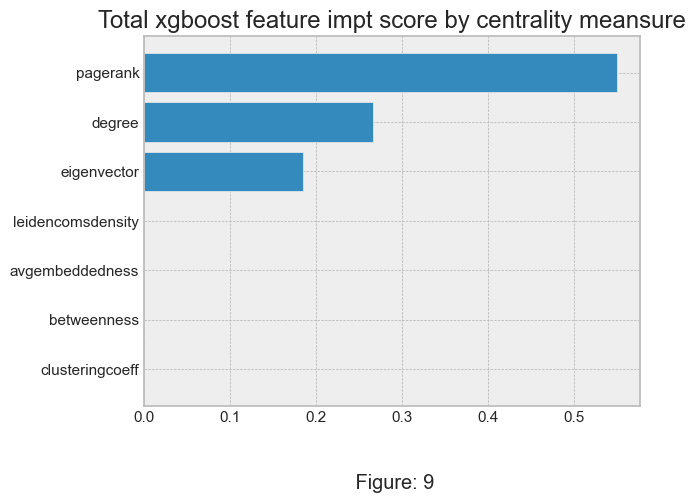

In [98]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")
plt.xlabel("\n\n Figure: 9")

## Densevectors, Unitvectors and PCAs of them

What are densevectors?
=====================

We explain densevectors with examples from `talkingData`. `talkingData` has five categorical features: `ip, app, os, channel` and `device`. We concatenate these features to create more features, as: `ip, app, os, channel , device, app_p_device, app_p_channel, os_p_channel`. Thereafter, we created numeric features from them. Names of numeric features start with one of the centrality measures' prefix, such as: `deg_, pr_, eig_, bet_ and clu`. Thus, in every row, every level of a feature, say, `app` has corresponding 'dense' vector. A dataframe of densevectors of `app` would be as:  

| app | deg_app_ck_channel | deg_app_ck_device |  pr_app_ck_ip |   
| --- | --- | --- | -- |
| 213 | 0.324 | 0.152 | 0.0923 |  
| 214 | 0.321 | 0.126 | 0.0239 |  
| 321 |  0.451 | 0.156 | 0.067 |
| --- | --- | --- | --- |
| --- | --- | --- | --- |
| 214 | 0.109 | 0.328 | 0.802 |  


For, `app` feature, for level, 213, we have two dense vectors: one is: [0.324,0.152,0.0923...] and the other is: [0.109, 0.328, 0.802...].

<u>Note</u>: Features such as: `pr_app_p_os_ck_ip,  'deg_app_p_channel_ck_os' .. ` are derived from concatenated columns and, hence, would not be a part of dense vector for `app`.

Similar to above we would have dataframes of dense vectors for 'ip', 'os' and others. An example:

| os | deg_os_ck_channel | deg_os_ck_device |  pr_os_ck_ip |   
| --- | --- | --- | -- |
| 101 | .0324 | 0.098 | 0.3423 |  
| 10 | 0.9021 | 0.378 | 0.8239 |  
| 210 |  0.1451 | 0.256 | 0.967 |
| --- | --- | --- | --- |
| --- | --- | --- | --- |
| 87 | 0.1109 | 0.128 | 0.232 |  

Our numerically transformed (*composite*) train/test dataframes (obtained using `ct.transform()` ), `train_trans`, and `test_trans`, can be taken as horizontal concatenation of all these dataframes of densevectors. Thus, to repeat, dense vectors for `'app'` (in our small example limited to few columns) would be:<br>

> `train_trans[['deg_app_ck_channel', 'deg_app_ck_device', 'deg_app_ck_ip', 'deg_app_ck_os','pr_app_ck_device', 'pr_app_ck_ip', 'pr_app_ck_os' ]]`<br>

If a level occurs multiple times (as it normally would) then there are multiple corresponding rows of vectors. Given a cat col, we first collect in a DataFrame all related columns, as for example below for `'app'` column. Note here that here level '213' occurs twice.




What are unitvectors
====================

Once the dataframe of densevectors, per cat_col, is extracted, we apply row-wise normalization (`l2` norm). Such normalized rows are unitvectors for corresponding levels. We, therefore, have a dataframe of unitvectors for every cat_col. Method, `vectorsToTSV()` takes `X_train_trans`/`X_test_trans` (with 'target' column) as input and outputs a dictionary whose keys are elements of cat_col and values are dataframes of unitvectors. If `take_mean` parameter is True, a final `'unitvector'` for each level, say, of 'app' (213) would be calculated by taking mean of corresponding rows.

PCA of unitvectors
==================

We, further, take PCAs of each dataframe of unitvectors and concatenate them. Here is an example of PCAs of unitvectors for `os`.

| os | os_pc0 | os_pc1 |  os_pc2 |   
| --- | --- | --- | -- |
| 101 | -0.34 | -2.31 | -0.44 |  
| 10 | 0.97 | -1.12 | 0.98 |  
| 210 |  0.23 | 0.34 | 0.99 |
| --- | --- | --- | --- |
| --- | --- | --- | --- |
| 87 | 2.56 | 0.61 | 0.97 |  

Similary, PCAs would be there for unitvectors corresponding to other `cat_cols`; each one is a pandas DataFrame. We concatenate them to produce one composite dataframe. Method, '_pcaAndConcat()`, would do this work for us.

Properties of PCAs of unitvectors
================================

PCAs of unitvectors have some good properties. We have used the first principal components of all unitvectors in our experiments. Number of these principal components are as many as the number of categorical features digested by thr `CatEncodersFamily` class.

>a. These first principal components (PC0s), on XGBoost modeling give almost the same results as that with the original categorical features. There are minor deteriorations in AUC score and in F1 score.   

> b. Their feature importance is almost in the same order as that of categorical features.

> c. After passing them through appropriate imblearn package classes, in all cases, on modeling, they give higher F1 score and about the same AUC.

Results
=======

Here is a compilation of results from what follows. PC0s after a little processing give more than double F1 score.


| Data | Best AUC | F1 score |  Recall |   
| --- | --- | --- | -- |
| Original data with all cat cols| <b>0.75006940</b> | 0.15 | 0.09 |
| Original data with those cat cols as exist in PC0s | 0.0.7494159 | 0.15 | 0.09 |
| PCAs of Unitvectors | 0.74447243 | 0.12 | 0.07 |  
| PC0s of unitvectors | 0.7362513 | 0.15 | 0.08 |  
| Undersampling with `EditedNearestNeighbours` of PC0s |  0.728930 | <b>0.34</b> | <b>0.31</b> |

Feature importance ranking:

| Rank | Original data feature name | PC0 feature name |     
| --- | --- | --- |
| 1| <b>0.75006940</b> | 0.15 |
| 2 | 0.0.7494159 | 0.15 |
| 3 | 0.74447243 | 0.12 |
| 4 | 0.7362513 | 0.15 |
| 5 |  0.728930 | <b>0.34</b> |



## Derive unitvectors
tsv files and meta files created in unitvectors folder can be fed into embedding projector (unfortunately files have large size and there is problem loading into Embedding Projector)

### Readback saved data

In [ ]:
# 21.2 Readback all saved files:

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test for concatenation
#        of cat cols to be possible with transformed data:

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Recheck indexing:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)/(1499627, 603)/(1499698, 765)
y_train.shape       # (1501119,)/(1499627, )
test_trans.shape    # (499831, 591)/(499876, 603)/(499900, 765)
y_test.shape        # (500374,)/(499876, )


f"Total cols in X_train: {X_train.shape[1]}"
# 21.2.4 Our list of cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

f"Length of cat cols: {len(cat_cols)}"

# 21.2.5 Remaining cols not treated as cat cols:
rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_ip','device_id',]  # 6 cols
f"Length of remaining cols: {len(rem_cols)}"



# 21.3 Concat rem_cols with transformed data:
# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
transcols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate (exclude device_id and device):
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[transcols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[transcols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1499493, 576)/(1499627, 588) (603-19+4 = 588)/(1499698, 765)/(1499698, 750)
X_test_trans.shape   # (499831, 576)/(499876, 588)/(499900, 750)/(1499698, 750)

# 21.7 Read back saved imputed data:

X_train_trans_imputed = pd.read_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

#  21.7.1 Check
X_train_trans_imputed.shape  # (1501119, 586)/(1499493, 576)/(1499627, 588)/(1499698, 750)
X_test_trans_imputed.shape   # (500374, 586)/(499831, 576)/(499876, 588)/(499900, 750)

# 21.8 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

771

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1102,1665,3,3667,107,0,1203,1,...,0.151011,0.271186,0.032768,0.009207,0.203390,0.068588,0.010675,0.915254,0.142844,0.019491
1,1005,0,359,3339,1,3667,107,0,563,1,...,-0.034182,0.694915,0.141788,0.016860,0.457627,0.170485,0.020274,0.915254,0.143742,0.019360


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1575,2720,5,3277,6,4,4606,1,...,0.118601,0.559322,0.081644,0.015594,0.186441,0.057565,0.011602,0.915254,0.142844,0.019491
1,1005,0,359,3339,1,3667,107,0,847,1,...,0.113822,0.711864,0.142679,0.017328,0.491525,0.173426,0.022475,0.949153,0.144855,0.020258


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1102,1665,3,3667,107,0,184979,384356,...,250,2162,2,39,100101,33,10,3,30,15
1,1005,0,359,3339,1,3667,107,0,184979,51728,...,50,1722,0,35,-1,79,10,1,21,6


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1575,2720,5,3277,6,4,184979,33570,...,50,122,3,1327,-1,15,10,3,23,15
1,1005,0,359,3339,1,3667,107,0,184979,914979,...,50,2616,0,35,-1,51,10,3,30,13


(1499698, 765)

(1499698,)

(499900, 765)

(499900,)

'Total cols in X_train: 25'

'Length of cat cols: 19'

'Length of remaining cols: 6'

(1499698, 750)

(499900, 750)

(1499698, 750)

(499900, 750)

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], cutoff=4,
                  mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

In [ ]:
# 22.0 Now horizontally concatenate (exclude device_id and device):

X_train_trans_imputed = pd.concat([X_train[cat_cols], X_train_trans_imputed ],  axis = 1)
X_test_trans_imputed = pd.concat([X_test[cat_cols], X_test_trans_imputed ], axis = 1)

X_train_trans_imputed.shape # (1499627, 607) ((603-19+4) +19 = 607 )/(1499698, 769)
X_test_trans_imputed.shape # (499876, 607)   ((603-19+4) +19 = 607)/(499900, 769)

(1499698, 769)

(499900, 769)

In [ ]:
# 22.0.0.1 Columns included all cat_cols as also transformed columns+time cols:

X_train_trans_imputed.columns[:30]
X_train_trans_imputed.columns[-25:]

Index(['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid',
       'appdomain', 'appcategory', 'devicemodel', 'devicetype',
       'deviceconntype', 'Cfourteen', 'Cfifteen', 'Csixteen', 'Cseventeen',
       'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone', 'day', 'dayofweek',
       'hour_time', 'month', 'deg_Cone_ck_bannerpos', 'eig_Cone_ck_bannerpos',
       'pr_Cone_ck_bannerpos', 'eig_Cone_ck_siteid', 'eig_Cone_ck_sitedomain',
       'eig_Cone_ck_sitecategory', 'deg_Cone_ck_appid'],
      dtype='object')

Index(['pr_Ctwentyone_ck_appcategory', 'deg_Ctwentyone_ck_devicemodel',
       'eig_Ctwentyone_ck_devicemodel', 'pr_Ctwentyone_ck_devicemodel',
       'deg_Ctwentyone_ck_devicetype', 'eig_Ctwentyone_ck_devicetype',
       'pr_Ctwentyone_ck_devicetype', 'eig_Ctwentyone_ck_deviceconntype',
       'eig_Ctwentyone_ck_Cfourteen', 'deg_Ctwentyone_ck_Cfifteen',
       'eig_Ctwentyone_ck_Cfifteen', 'pr_Ctwentyone_ck_Cfifteen',
       'deg_Ctwentyone_ck_Csixteen', 'eig_Ctwentyone_ck_Csixteen',
       'pr_Ctwentyone_ck_Csixteen', 'eig_Ctwentyone_ck_Cseventeen',
       'deg_Ctwentyone_ck_Ceighteen', 'eig_Ctwentyone_ck_Ceighteen',
       'pr_Ctwentyone_ck_Ceighteen', 'deg_Ctwentyone_ck_Cnineteen',
       'eig_Ctwentyone_ck_Cnineteen', 'pr_Ctwentyone_ck_Cnineteen',
       'deg_Ctwentyone_ck_Ctwenty', 'eig_Ctwentyone_ck_Ctwenty',
       'pr_Ctwentyone_ck_Ctwenty'],
      dtype='object')

In [ ]:
# 22.0.0.2:
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)
X_train_trans_imputed = X_train_trans_imputed[fe_1]
X_test_trans_imputed = X_test_trans_imputed[fe_1]

In [ ]:
# 22.0.1 Now horizontally concatenate (exclude device_id and device):

X_train_trans_imputed = pd.concat([X_train[cat_cols], X_train_trans_imputed ],  axis = 1)
X_test_trans_imputed = pd.concat([X_test[cat_cols], X_test_trans_imputed ], axis = 1)

X_train_trans_imputed.shape # (1499627, 607) ((603-19+4) +19 = 607 )
X_test_trans_imputed.shape # (499876, 607)   ((603-19+4) +19 = 607)

(1499698, 438)

(499900, 438)

In [ ]:
# 22.0.2 'target' is not here

'target' in list(X_train_trans_imputed.columns)
'target' in list(X_test_trans_imputed.columns)

False

False

In [ ]:
# 22.0.3 Get target data col.
#        Needed for generation of meta-data file:

X_test_trans_imputed['target']  =  y_test
X_train_trans_imputed['target'] =  y_train

In [ ]:
# 22.0.4 Derive unit vectors:

p = Path(avazuunitvecs)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(X_train_trans_imputed,
                           take_mean = False,
                           filepath = avazuunitvecs ,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )



Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['deviceconntype', 'Ceighteen']
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'c:\avazu\allmodels\unitvectors'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [ ]:
# 22.1 Save dict:

utils.savePythonObject(vec_tr, "vec_tr.pkl", avazuunitvecs )

Object saved to: c:\avazu\allmodels\unitvectors\vec_tr.pkl


In [ ]:
# 22.2 Unit vectors from test data. But not being saved to file:

vec_te,_ = ct.vectorsToTSV(X_test_trans_imputed,
                           take_mean = False,
                           filepath = avazuunitvecs ,
                           impute = True,
                           saveVectorsToDisk = False
                           )

19

Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['deviceconntype', 'Ceighteen']


### Save unitvectors files
Also save output dictionaries for later use

In [ ]:
# 22.3 Save dict:

utils.savePythonObject(vec_te, "vec_te.pkl",avazuunitvecs )

Object saved to: c:\avazu\allmodels\unitvectors\vec_te.pkl


### Restore unitvectors files

In [ ]:
# 22.4 Restore back:

vec_tr = utils.restorePythonObject( "vec_tr.pkl", avazuunitvecs )
vec_te = utils.restorePythonObject("vec_te.pkl",avazuunitvecs )

### Using unit vectors to transform train/test data

In [ ]:
# 22.4.1

vectr = vec_tr.copy()
vecte = vec_te.copy()

In [ ]:
# 22.4.2

for key,values in vectr.items():
    print(key,vectr[key].shape[1])

Cone 6
bannerpos 4
siteid 35
sitedomain 33
sitecategory 12
appid 40
appdomain 32
appcategory 17
devicemodel 52
Cfourteen 45
Cfifteen 3
Csixteen 2
Cseventeen 50
Cnineteen 27
Ctwenty 31
Ctwentyone 26


In [ ]:
# 22.4.3

del vectr['devicetype']
del vecte['devicetype']

In [ ]:
# 23.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vectr, vecte, n_components = 2)

# 23.1

cctr.head(3)
ccte.head(3)

# 23.2

cctr.shape   #  (1499493, 48)/(1499627, 48)
ccte.shape   #  (499831, 48)/(499876, 48)

Performing PCA for Cone for train data
Performing PCA for Cone for test data
Performing PCA for bannerpos for train data
Performing PCA for bannerpos for test data
Performing PCA for siteid for train data
Performing PCA for siteid for test data
Performing PCA for sitedomain for train data
Performing PCA for sitedomain for test data
Performing PCA for sitecategory for train data
Performing PCA for sitecategory for test data
Performing PCA for appid for train data
Performing PCA for appid for test data
Performing PCA for appdomain for train data
Performing PCA for appdomain for test data
Performing PCA for appcategory for train data
Performing PCA for appcategory for test data
Performing PCA for devicemodel for train data
Performing PCA for devicemodel for test data
Performing PCA for Cfourteen for train data
Performing PCA for Cfourteen for test data
Performing PCA for Cfifteen for train data
Performing PCA for Cfifteen for test data
Performing PCA for Csixteen for train data
Performing

,pcCone0,pcCone1,pcbannerpos0,pcbannerpos1,pcsiteid0,pcsiteid1,pcsitedomain0,pcsitedomain1,pcsitecategory0,pcsitecategory1,...,pcCsixteen0,pcCsixteen1,pcCseventeen0,pcCseventeen1,pcCnineteen0,pcCnineteen1,pcCtwenty0,pcCtwenty1,pcCtwentyone0,pcCtwentyone1
0,0.581001,0.05918,0.605965,-0.603488,-4.609655,3.786494,-6.752192,4.012943,-0.465173,4.405540,...,1.101649,2.011192,14.887827,-4.186817,0.143371,-2.198293,1.514483,-3.040481,-13.593432,-4.702157
1,0.581001,0.05918,0.605965,-0.603488,-4.156096,-1.396915,-5.641333,-1.220889,-1.323852,0.292909,...,-0.189521,-0.085208,-0.834507,-0.856240,-4.536388,1.349947,-3.983723,0.721994,0.246743,1.409277
2,0.581001,0.05918,0.605965,-0.603488,5.657921,0.091492,5.471102,-0.195994,-1.722176,-1.167692,...,-0.189521,-0.085208,-1.142674,-0.039829,-4.536388,1.349947,-3.983723,0.721994,3.188552,-1.876509


,pcCone0,pcCone1,pcbannerpos0,pcbannerpos1,pcsiteid0,pcsiteid1,pcsitedomain0,pcsitedomain1,pcsitecategory0,pcsitecategory1,...,pcCsixteen0,pcCsixteen1,pcCseventeen0,pcCseventeen1,pcCnineteen0,pcCnineteen1,pcCtwenty0,pcCtwenty1,pcCtwentyone0,pcCtwentyone1
0,0.580452,0.051902,0.624267,-0.583277,5.659823,0.089795,5.474217,-0.191181,-1.704516,-1.181824,...,-0.187025,-0.082874,0.601900,2.110449,4.253309,0.136561,-3.574029,0.680895,-3.120828,1.008538
1,0.580452,0.051902,0.624267,-0.583277,-4.159004,-1.396196,-5.637734,-1.216660,-1.315245,0.292787,...,-0.187025,-0.082874,11.068941,3.886238,-4.532751,1.353721,-3.574029,0.680895,0.510179,-0.201777
2,0.580452,0.051902,0.624267,-0.583277,5.659823,0.089795,5.474217,-0.191181,-1.704516,-1.181824,...,-0.187025,-0.082874,-1.544234,-1.881316,-4.532751,1.353721,3.709878,-0.156455,3.213846,-1.887132


(1499698, 32)

(499900, 32)

### Save unitvectors transformed train/test

In [ ]:
# 23.3 Save cctr/ccte

cctr.to_pickle(avazuunitvecs  / "cctr.pkl")
ccte.to_pickle(avazuunitvecs  / "ccte.pkl")


### Readback unitvectors transformed train/test

In [ ]:
# 24.0 Read back cctr/ccte

cctr = pd.read_pickle(avazuunitvecs  / "cctr.pkl")
ccte = pd.read_pickle(avazuunitvecs  / "ccte.pkl")

# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (1499049, 48)/(1499627, 48)/(1499698, 32)
ccte.shape # (499684, 48)/(499876, 48)/(499900, 32)

,pcCone0,pcCone1,pcbannerpos0,pcbannerpos1,pcsiteid0,pcsiteid1,pcsitedomain0,pcsitedomain1,pcsitecategory0,pcsitecategory1,...,pcCsixteen0,pcCsixteen1,pcCseventeen0,pcCseventeen1,pcCnineteen0,pcCnineteen1,pcCtwenty0,pcCtwenty1,pcCtwentyone0,pcCtwentyone1
0,0.581001,0.05918,0.605965,-0.603488,-4.609655,3.786494,-6.752192,4.012943,-0.465173,4.405540,...,1.101649,2.011192,14.887827,-4.186817,0.143371,-2.198293,1.514483,-3.040481,-13.593432,-4.702157
1,0.581001,0.05918,0.605965,-0.603488,-4.156096,-1.396915,-5.641333,-1.220889,-1.323852,0.292909,...,-0.189521,-0.085208,-0.834507,-0.856240,-4.536388,1.349947,-3.983723,0.721994,0.246743,1.409277


,pcCone0,pcCone1,pcbannerpos0,pcbannerpos1,pcsiteid0,pcsiteid1,pcsitedomain0,pcsitedomain1,pcsitecategory0,pcsitecategory1,...,pcCsixteen0,pcCsixteen1,pcCseventeen0,pcCseventeen1,pcCnineteen0,pcCnineteen1,pcCtwenty0,pcCtwenty1,pcCtwentyone0,pcCtwentyone1
0,0.580452,0.051902,0.624267,-0.583277,5.659823,0.089795,5.474217,-0.191181,-1.704516,-1.181824,...,-0.187025,-0.082874,0.601900,2.110449,4.253309,0.136561,-3.574029,0.680895,-3.120828,1.008538
1,0.580452,0.051902,0.624267,-0.583277,-4.159004,-1.396196,-5.637734,-1.216660,-1.315245,0.292787,...,-0.187025,-0.082874,11.068941,3.886238,-4.532751,1.353721,-3.574029,0.680895,0.510179,-0.201777


(1499698, 32)

(499900, 32)

### xgboost modeling with unitvectors

In [ ]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )


tr_X   =  cctr
test_X =  ccte
ytrain =  y_train
ytest  =  y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[17:12:32] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:12:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4150 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73338	validation_1-auc:0.72020
[17:12:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3988 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73727	validation_1-auc:0.72312
[17:12:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3948 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.73955	validation_1-auc:0.72543
[17:12:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4082 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.74080	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 24.1.1 Save and restore estimators:

utils.savePythonObject(model_vec, "model_vec.pkl", avazudata)



Object saved to: c:\avazu\allmodels\datafiles\model_vec.pkl


In [ ]:
# 24.1.2 Restore

model_vec = utils.restorePythonObject("model_vec.pkl", avazudata)

In [ ]:
# 24.2 Best scores:

model_vec.best_score   # 0.7461641340935019
print("\n")
model_vec.best_iteration  # 59

0.744472437885137

157

#### Classification report


In [ ]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.62      0.07      0.12     85094

    accuracy                           0.83    499900
   macro avg       0.73      0.53      0.51    499900
weighted avg       0.80      0.83      0.77    499900



### xgboost modeling with only pc0s of unitvectors

In [ ]:
# 25.0 Columns containing only Ist PCs:

pc0cols = [i for i in cctr.columns if '0' in i]
print(pc0cols)
len(pc0cols)  # 16

['pcCone0', 'pcbannerpos0', 'pcsiteid0', 'pcsitedomain0', 'pcsitecategory0', 'pcappid0', 'pcappdomain0', 'pcappcategory0', 'pcdevicemodel0', 'pcCfourteen0', 'pcCfifteen0', 'pcCsixteen0', 'pcCseventeen0', 'pcCnineteen0', 'pcCtwenty0', 'pcCtwentyone0']


16

In [ ]:
# 25.1 How good are pc0's of respective unit vectors and which one is most important?
#      Time features are not included.

model_vec_pc0 = xgb.XGBClassifier( n_estimators= 500,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.8,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )


tr_X =    cctr[pc0cols]
test_X =  ccte[pc0cols]
ytrain =  y_train
ytest = y_test
r

model_vec_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

44

[17:52:50] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:52:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1144 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.72050	validation_1-auc:0.70301
[17:52:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1188 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.72339	validation_1-auc:0.70590
[17:52:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1234 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.72570	validation_1-auc:0.71055
[17:52:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1192 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.72649	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 25.2 Save model:

utils.savePythonObject(model_vec_pc0, "model_vec_pc0.pkl", avazuestimators  )

Object saved to: c:\avazu\allmodels\estimators\model_vec_pc0.pkl


In [102]:
# 25.3 Restore model:

model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", avazuestimators  )

In [ ]:
# 25.4 Best scores:

model_vec_pc0.best_score   # 0.7436607269651191/0.7348892041123435/0.7362513524258832
print("\n")
model_vec_pc0.best_iteration  # 247/242

0.7362513524258832

242

In [ ]:
# 24.5 Classification report:

pred_vec = model_vec_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.58      0.08      0.15     85094

    accuracy                           0.83    499900
   macro avg       0.71      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



### xgboost modeling original data but with those cols that exist in pc0s

In [ ]:
# 26.0 List of cat-cols in X_train excluding deviceid and deviceip:

len(pc0cols)

pccols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid',
          'appdomain', 'appcategory', 'devicemodel', 'Cfourteen', 'Cfifteen',
          'Csixteen', 'Cseventeen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']

len(pccols) # 16

16

16

In [ ]:
# 26.1  Determine feature importance in actual data:
#       Use the same 16 features as exist in pc0s
#      (Time features, therefore, are not included.)

model_orig_few = xgb.XGBClassifier( n_estimators= 500,
                                    verbosity = 3,
                                    eta = 0.06,
                                    max_depth = 10,
                                   subsample = 0.8,
                                   random_state = rng,
                                   #reg_lambda = 1.5,
                                 )


tr_X =    X_train[pccols]
test_X =  X_test[pccols]
ytrain =  y_train
ytest = y_test


model_orig_few.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

In [ ]:
# 26.2 Save model:

utils.savePythonObject(model_orig_few, "model_orig_few.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_orig_few.pkl


In [100]:
# 26.3 Restore model
model_orig_few = utils.restorePythonObject("model_orig_few.pkl", avazudata)

In [ ]:
# 26.4 Best scores:

model_orig_few.best_score   # 0.7485019371833646
print("\n")
model_orig_few.best_iteration  # 499

0.7494159035776002

499

In [ ]:
# 26.5 Classification report:

pred_vec = model_orig_few.predict(X_test[pccols])
few_cl=classification_report(ytest,pred_vec)
print(few_cl)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414806
           1       0.60      0.09      0.15     85094

    accuracy                           0.83    499900
   macro avg       0.72      0.54      0.53    499900
weighted avg       0.80      0.83      0.78    499900



### Comparing xgboost feature importance
Finally, let us now compare feature importance of transformed univectors data with just pc0 columns and the actual data with the same set of cat columns:

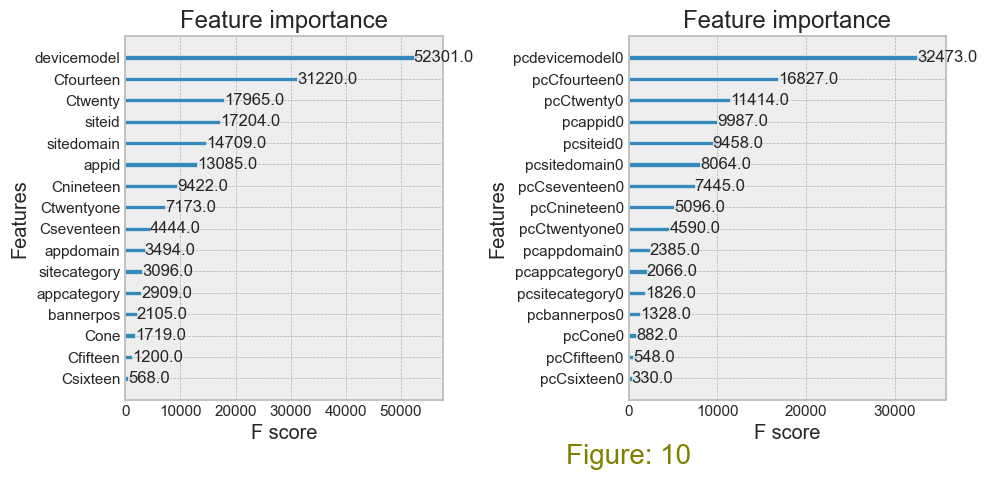

In [114]:
# 26.6 pc0 columns vs cat columns importance

fix,ax = plt.subplots(nrows =1, ncols=2, figsize = (10,5))
_=xgb.plot_importance(model_orig_few, ax = ax[0])
# 25.1 Which PC0 columns have high xgboost impt
_=xgb.plot_importance(model_vec_pc0, ax = ax[1])

txt = "Figure: 10"
_=plt.text(0, -4.0, txt, ha='center', fontsize = 20, color = "olive")
plt.tight_layout()

### Undersampling of unitvectors pc0s columns

In [ ]:
# 27.0 Call imblearn library:
#       We find EditedNearestNeighbours the best in this case

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

In [ ]:
# 27.0.1 Columns containing only Ist PCs:

pc0cols = [i for i in cctr.columns if '0' in i]
print(pc0cols)
len(pc0cols)  # 12

In [ ]:
# 27.1 Undersample/cleanup unitvectors datawith only pc0s:

undersample = EditedNearestNeighbours()
X_res_pc0, y_res_pc0 = undersample.fit_resample(cctr[pc0cols], y_train.values)


# 27.1.1 Data shape
X_res_pc0.shape  #  (3737267, 5)
y_res_pc0.shape  #  (3737267,)

11761

(1077147, 16)

(1077147,)

In [ ]:
# 27.1.2 Save above files:

X_res_pc0.to_pickle(avazudata / "X_res_pc0.pkl")
y_res_pc0 = pd.DataFrame(y_res_pc0, columns= [ 'click'])
y_res_pc0.to_pickle(avazudata / "y_res_pc0.pkl")
gc.collect()

0

In [ ]:
# 27.1.3 Read back:

X_res_pc0 = pd.read_pickle(avazudata / "X_res_pc0.pkl")
y_res_pc0 = pd.read_pickle(avazudata / "y_res_pc0.pkl")
y_res_pc0.value_counts(normalize = True) # 76:23
y_train.value_counts(normalize = True) # 83:17

click
0        0.763002
1        0.236998
dtype: float64

0    0.829778
1    0.170222
Name: click, dtype: float64

In [ ]:
# 27.2 xgboost Modeling with undersampled data:

model_res_pc0 = xgb.XGBClassifier( n_estimators= 400,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res_pc0
test_X = ccte[pc0cols]
ytrain = y_res_pc0
ytest =  y_test


model_res_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )

0

[18:22:46] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:22:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1100 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.78669	validation_1-auc:0.68693
[18:22:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1076 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.79300	validation_1-auc:0.69041
[18:22:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1080 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.79433	validation_1-auc:0.69190
[18:22:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1106 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.79656	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 27.2.1 Save model:

utils.savePythonObject(model_res_pc0, "model_res_pc0.pkl", avazuestimators )

Object saved to: c:\avazu\allmodels\estimators\model_res_pc0.pkl


In [116]:
# 27.2.2 Restore model:

model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", avazuestimators )

In [ ]:
# 27.2.3 Best scores:

model_res_pc0.best_score   # 0.7352568578802253
print("\n")
model_res_pc0.best_iteration  # 139

0.7289305732606125

186

In [ ]:
# 27.2.4 Classification report:

pred_vec = model_res_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88    414806
           1       0.37      0.31      0.34     85094

    accuracy                           0.79    499900
   macro avg       0.62      0.60      0.61    499900
weighted avg       0.78      0.79      0.79    499900



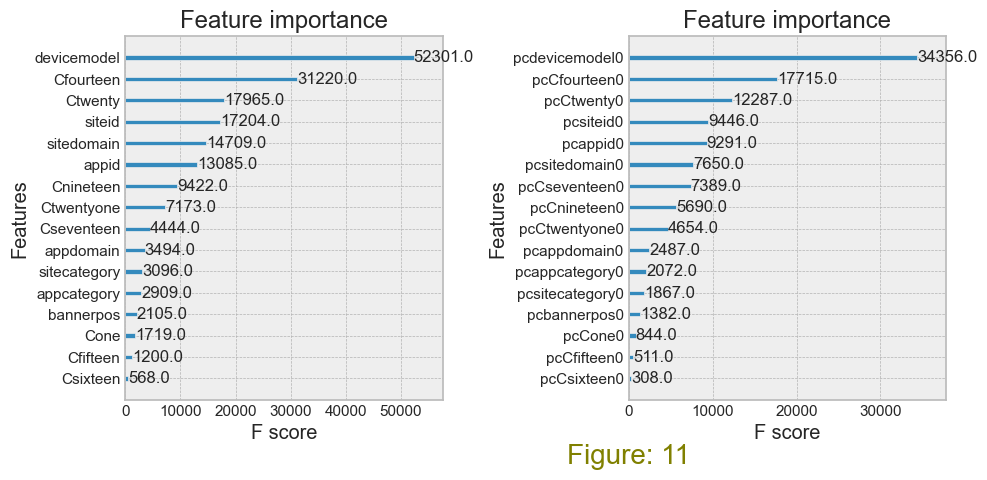

In [117]:
# 27.2.5 Comparing xgboost feature importance, once again:
#  Original data vs univectors data with just pc0s

fix,ax = plt.subplots(nrows =1, ncols=2, figsize = (10,5))
_=xgb.plot_importance(model_orig_few, ax = ax[0])

# 27.2.6 Which PC0 columns have high xgboost impt
_=xgb.plot_importance(model_res_pc0, ax = ax[1])

txt = "Figure: 11"
_=plt.text(0, -4.0, txt, ha='center', fontsize = 20, color = "olive")
plt.tight_layout()

### Density plots
Almost a) the same xgboost feature importance rankings, b) almost the same AUC scores and c) same classification reports,  between the original data (having discrete features) and in unitvectors (pc0s) data (having continuous features), points towards one-to-one relationships between the discrete features and the corresponding continupos features.  

To understand discrete features better, we can draw density plots of corresponding continuous features.

In [119]:
## Density plots
# 28.0 Read back cctr/ccte
cctr = pd.read_pickle(avazuunitvecs  / "cctr.pkl")

In [120]:
# 28.1
pc0cols = [i for i in cctr.columns if '0' in i]
print(pc0cols)

['pcCone0', 'pcbannerpos0', 'pcsiteid0', 'pcsitedomain0', 'pcsitecategory0', 'pcappid0', 'pcappdomain0', 'pcappcategory0', 'pcdevicemodel0', 'pcCfourteen0', 'pcCfifteen0', 'pcCsixteen0', 'pcCseventeen0', 'pcCnineteen0', 'pcCtwenty0', 'pcCtwentyone0']


In [121]:
# 28.2
cctr['target']= y_train.reset_index(drop = True)

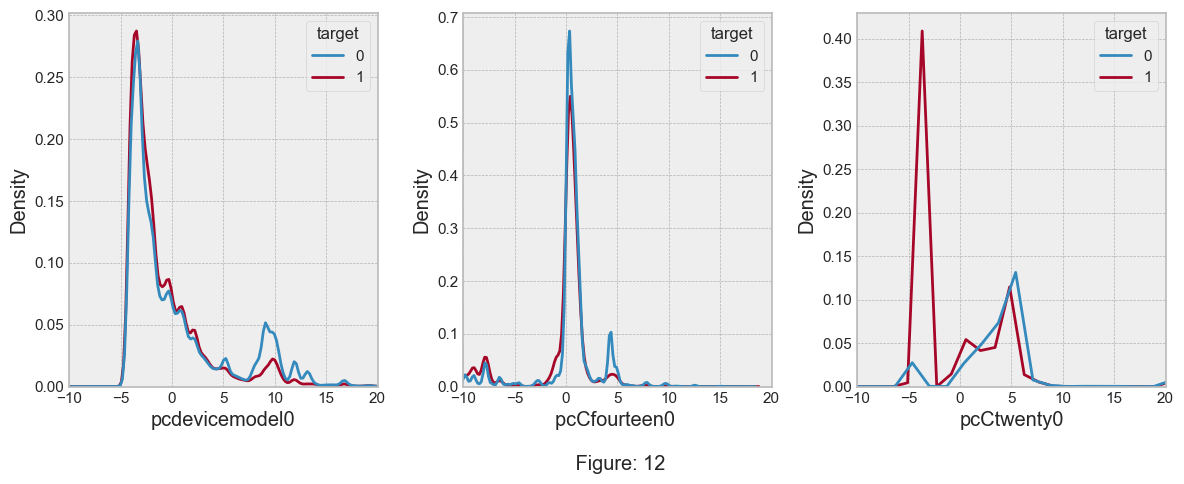

In [145]:
# 28.3
# https://stackoverflow.com/a/42734379
# https://stackoverflow.com/a/63895570

fig,ax = plt.subplots(nrows = 1,ncols = 3, figsize = (12,5))

_=sns.kdeplot(cctr,
              x="pcdevicemodel0",
              hue="target",
              ax = ax[0],
              common_norm = False)
_=ax[0].set_xlim(-10, 20)

_=sns.kdeplot(cctr,
              x="pcCfourteen0",
              hue="target",
              ax = ax[1],
              common_norm = False)
_=ax[1].set_xlim(-10, 20)
_=ax[1].set_xlabel("pcCfourteen0 \n\n Figure: 12")

_=sns.kdeplot(cctr,
              x="pcCtwenty0",
              hue="target",
              ax = ax[2],
              common_norm = False)
_=ax[2].set_xlim(-10, 20)

# Needs customization
#txt = "Figure: 12"
#_=plt.text(-20, -0.10, txt, ha='center', fontsize = 20, color = "olive")
plt.tight_layout()

In [142]:
# 28.4 Take a sample of cctr for contour plots between two features:

_, cc_test, _ , y_cc_test = train_test_split(
                                              cctr,
                                              y_train,
                                              test_size = 0.25,
                                              stratify= y_train,
                                              random_state= rng)

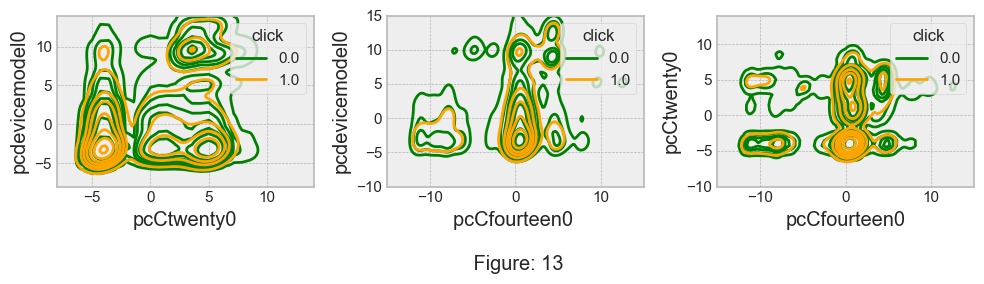

In [144]:
# 28.5 Contour plots of two-features at a time
#      First three impt features are considered

fig,ax = plt.subplots(nrows = 1,ncols = 3,figsize=(10,3))
_= sns.kdeplot(data=cc_test,
               x="pcCtwenty0",
               y = "pcdevicemodel0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
               ax = ax[0])
_=ax[0].set_xlim(-8, 14)
_=ax[0].set_ylim(-8, 14)

_= sns.kdeplot(data=cc_test,
               x="pcCfourteen0",
               y = "pcdevicemodel0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
              ax = ax[1])
_=ax[1].set_xlim(-15, 15)
_=ax[1].set_ylim(-10, 15)
_=ax[1].set_xlabel("pcCfourteen0 \n\n Figure: 13")

_= sns.kdeplot(data=cc_test,
               x="pcCfourteen0",
               y = "pcCtwenty0" ,
               hue = y_cc_test,
               palette = ['green', 'orange'],
               ax = ax[2])
_=ax[2].set_xlim(-15, 15)
_=ax[2].set_ylim(-10, 14)
plt.tight_layout()

## A Summary-- an Overall comparative picture

### Readback limited stored data

In [163]:
# 29.0
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 29.1   Reindex X_train/X_test for concatenation
#        of cat cols to be possible with transformed data
X_test = X_test.reset_index(drop = True)




# 29.2 Our list of cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols



# 29.3 Remaining cols not treated as cat cols:
rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_ip','device_id',]  # 6 cols

# 29.4 Concat rem_cols with transformed data:
#      Columns after transformeation to be considered. Ignore initial cat_cols
transcols = test_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate (exclude device_id and device):
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[transcols] ], axis = 1)


# 13.2.1 Read back saved imputed data:

X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")


# 14.1 Read back saved data:

pca_test =  pd.read_pickle(Path(avazudata) / "pca_test.pkl")

# 24.0 Read back cctr/ccte
ccte = pd.read_pickle(avazuunitvecs  / "ccte.pkl")
# 24.1 Columns containing only Ist PCs:
pc0cols = [i for i in ccte.columns if '0' in i]
Xte = X_test.copy()
_=Xte.pop('deviceid')
_=Xte.pop('deviceip')

pccols =  ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid', 
           'appdomain', 'appcategory', 'devicemodel', 'Cfourteen', 'Cfifteen', 
           'Csixteen', 'Cseventeen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']

### Readback models

In [147]:
# Model with original data
model_orig = utils.restorePythonObject("model_orig.pkl", avazudata )

# Model with transformed data
model_trans = utils.restorePythonObject("model_trans.pkl", avazudata)


#Model with original data but without deviceid and deviceip
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

# Model with important transfomed features
model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", avazudata)

# Get important features
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)

# Model with 95% pca of transformed features
model_pca = utils.restorePythonObject("model_pca.pkl", avazudata)

# Model after EditedNearestNeighbours on 95% pca data
model_en = utils.restorePythonObject("model_en.pkl", avazudata)

# Model after smoteenn on 95% pca data
model_sm = utils.restorePythonObject("model_sm.pkl", avazudata)

# Model with only unitvectors data
model_vec = utils.restorePythonObject("model_vec.pkl", avazudata)

# Model with original data but with with those columns whose unitvectors are available
model_orig_few = utils.restorePythonObject("model_orig_few.pkl", avazudata)

# 24.4 Model with pc0 columns of unitvectors
model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", avazuestimators  )

# Model after EditedNearestNeighbours on pc0 columns of unitvectors
model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", avazuestimators )


### Results

In [164]:
# 35.0 An all inclusive comparative table

re1 = []
re2 = []
re3 = []
re4 = []
re5 = []
re6 = []
re7 = []
re8 = []
re9 = []
re10 = []

table = [re1,re2,re3,re4,re5,re6,re7,re8,re9]

# 35.1 Predictions
p1 = model_orig.predict(X_test)
p2=  model_trans.predict(X_test_trans)
p3 = model_orig_noip.predict(Xte)
p4 = model_trans_impt.predict(X_test_trans[fe_1])
p5 = model_pca.predict(pca_test)
p6 = model_en.predict(pca_test)
p7 = model_sm.predict(pca_test)
p8 = model_vec.predict(ccte)
p9 = model_vec_pc0.predict(ccte[pc0cols])
p10 = model_orig_few.predict(X_test[pccols])


# 35.2 Dataframe Index
str1 = "Modeling with orig data"
str2 = "Modeling with transformed data (no deviceid/deviceip)"
str3 = "Modeling with orig data (no deviceid/deviceip)"
str4 = "Modeling with impt transformed features"
str5 = "Modeling with PCAs of transformed data"
str6 = "PCA data cleaned up with EditedNearestNeighbours"
str7 = "PCA data cleaned up with SMOTEENN"
str8 = "Modeling with unitvectors data"
str9 = "Modeling with unitvectors data--only pc0s"
str10 = "Modeling with orig data but for which univectors exist"

# 35.3
re1.append(str1)
re2.append(str2)
re3.append(str3)
re4.append(str4)
re5.append(str5)
re6.append(str6)
re7.append(str7)
re8.append(str8 )
re9.append(str9)
re10.append(str10)


# 35.4 AUC first
s1 = model_orig.best_score
s2=  model_trans.best_score
s3 = model_orig_noip.best_score
s4 = model_trans_impt.best_score
s5 = model_pca.best_score
s6 = model_en.best_score
s7 = model_sm.best_score
s8 = model_vec.best_score
s9 = model_res_pc0.best_score
s10 = model_orig_few.best_score

# 35.5
re1.append(s1)
re2.append(s2 )
re3.append(s3)
re4.append(s4)
re5.append(s5)
re6.append(s6)
re7.append(s7)
re8.append(s8)
re9.append(s9)
re10.append(s10)

# 35.6
f1 = f1_score(y_test.values, p1)
f2 = f1_score(y_test.values, p2)
f3 = f1_score(y_test.values, p3)
f4 = f1_score(y_test.values, p4)
f5 = f1_score(y_test.values, p5)
f6 = f1_score(y_test.values, p6)
f7 = f1_score(y_test.values, p7)
f8 = f1_score(y_test.values, p8)
f9 = f1_score(y_test.values, p9)
f10 = f1_score(y_test.values, p10)

# 35.7
re1.append(f1)
re2.append(f2)
re3.append(f3)
re4.append(f4)
re5.append(f5)
re6.append(f6)
re7.append(f7)
re8.append(f8)
re9.append(f9)
re10.append(f10)

# 35.8 kappa score
k1 = cohen_kappa_score(y_test.values,p1)
k2 = cohen_kappa_score(y_test.values,p2)
k3 = cohen_kappa_score(y_test.values,p3)
k4 = cohen_kappa_score(y_test.values,p4)
k5 = cohen_kappa_score(y_test.values,p5)
k6 = cohen_kappa_score(y_test.values,p6)
k7 = cohen_kappa_score(y_test.values,p7)
k8 = cohen_kappa_score(y_test.values,p8)
k9 = cohen_kappa_score(y_test.values,p9)
k10 = cohen_kappa_score(y_test.values,p10)

# 35.9
re1.append(k1)
re2.append(k2)
re3.append(k3)
re4.append(k4)
re5.append(k5)
re6.append(k6)
re7.append(k7)
re8.append(k8)
re9.append(k9)
re10.append(k10)


# 35.10 Accuracy score
a1 = accuracy_score(y_test.values,p1)
a2 = accuracy_score(y_test.values,p2)
a3 = accuracy_score(y_test.values,p3)
a4 = accuracy_score(y_test.values,p4)
a5 = accuracy_score(y_test.values,p5)
a6 = accuracy_score(y_test.values,p6)
a7 = accuracy_score(y_test.values,p7)
a8 = accuracy_score(y_test.values,p8)
a9 = accuracy_score(y_test.values,p9)
a10 = accuracy_score(y_test.values,p10)


# Matthews correlation Coef

# 35.8 Matthew correlation Coeff
m1 = matthews_corrcoef(y_test.values,p1)
m2 = matthews_corrcoef(y_test.values,p2)
m3 = matthews_corrcoef(y_test.values,p3)
m4 = matthews_corrcoef(y_test.values,p4)
m5 = matthews_corrcoef(y_test.values,p5)
m6 = matthews_corrcoef(y_test.values,p6)
m7 = matthews_corrcoef(y_test.values,p7)
m8 = matthews_corrcoef(y_test.values,p8)
m9 = matthews_corrcoef(y_test.values,p9)
m10 = matthews_corrcoef(y_test.values,p10)



# 35.11
re1.append(a1)
re2.append(a2)
re3.append(a3)
re4.append(a4)
re5.append(a5)
re6.append(a6)
re7.append(a7)
re8.append(a8)
re9.append(a9)
re10.append(a10)

In [165]:
# 36.0 Print table now
out = pd.DataFrame({"AUC score": [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10] ,
                   "f1 score" : [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10],
                   "kappa score" : [k1,k2,k3,k4,k5,k6,k7,k8,k9,k10],
                   "accuracy" : [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10],
                   "Matthews Cor Coef" : [m1,m2,m3,m4,m5,m6,m7,m8,m9,m10]
                   },

                    index = [str1,str2,str3,str4,str5,str6,str7,str8,str9,str10])

print(f"\n               lightorange is min of column and lightgreen is max of a columns")
out.style.\
highlight_min(color = 'orange', axis = 0).\
highlight_max(color = 'lightgreen', axis = 0)


               lightorange is min of column and lightgreen is max of a columns


,AUC score,f1 score,kappa score,accuracy,Matthews Cor Coef
Modeling with orig data,0.750069,0.151236,0.112460,0.834251,0.178753
Modeling with transformed data (no deviceid/deviceip),0.752946,0.156295,0.116280,0.834351,0.181834
Modeling with orig data (no deviceid/deviceip),0.749760,0.157421,0.116799,0.834171,0.181350
Modeling with impt transformed features,0.752679,0.158459,0.118344,0.834653,0.184655
Modeling with PCAs of transformed data,0.737737,0.141876,0.103604,0.832983,0.166423
PCA data cleaned up with EditedNearestNeighbours,0.738750,0.369000,0.238596,0.783851,0.238602
PCA data cleaned up with SMOTEENN,0.730574,0.402561,0.208605,0.636941,0.256650
Modeling with unitvectors data,0.744472,0.120432,0.090366,0.834179,0.163494
Modeling with unitvectors data--only pc0s,0.728931,0.145641,0.107816,0.833883,0.173751
Modeling with orig data but for which univectors exist,0.749416,0.149949,0.112252,0.834683,0.180767


In [167]:
# Add labels to bar chart
# Ref: https://stackoverflow.com/a/48372659/3282777

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

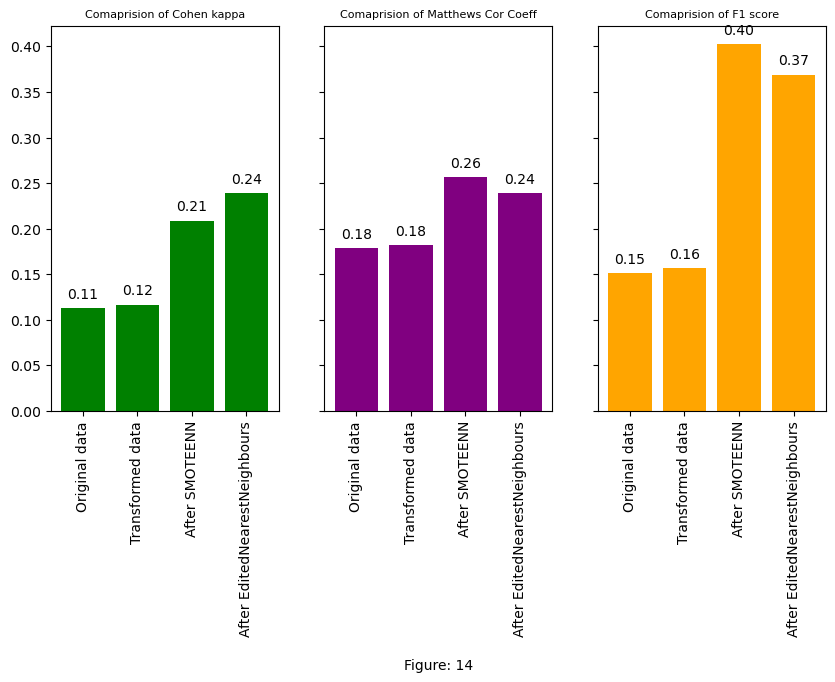

In [170]:
# Combined plots:
plt.style.use('default')
fig,ax = plt.subplots(1,3,sharey = True, figsize= (10,5))
xlabels = ['Original data', 'Transformed data', 'After SMOTEENN', 'After EditedNearestNeighbours']
yvalues_ck = [k1,k2,k7,k6]
yvalues_mcc = [m1,m2,m7,m6]
yvalues_f1 = [f1,f2,f7,f6]
ax[0].bar(xlabels,yvalues_ck,color = 'green');
ax[1].bar(xlabels,yvalues_mcc, color = 'purple');
ax[2].bar(xlabels,yvalues_f1, color = 'orange');
ax[0].set_xticklabels(xlabels, rotation=90)
ax[1].set_xticklabels(xlabels, rotation=90)
_=ax[1].set_xlabel("\nFigure: 14")

ax[2].set_xticklabels(xlabels, rotation=90)
ax[0].set_title("Comaprision of Cohen kappa", fontsize = 8)
ax[1].set_title("Comaprision of Matthews Cor Coeff", fontsize = 8)
ax[2].set_title("Comaprision of F1 score", fontsize = 8)
add_value_labels(ax[0])
add_value_labels(ax[1])
add_value_labels(ax[2])
plt.show();

## Some more experiments
Feature Engineering with clustering


In [ ]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 10,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20
Current index:  24
Current index:  28
Current index:  32
Current index:  36
Current index:  40
Current index:  44


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,2.889698,-0.597556,-0.605230,-0.983609,5.770558,-0.088779,0.976720,-0.682658,-6.472119,1.824779,...,1,0,1,0,8,0,1,5,5,2
1,-6.821252,-0.074456,0.273082,0.473605,-6.375553,-0.859748,0.679954,0.400250,1.803573,-2.779584,...,2,2,4,2,0,8,8,9,7,2
2,-6.821253,-0.073874,0.302884,0.500631,-6.375553,-0.859665,0.707247,0.438487,1.803671,-2.779428,...,2,2,4,1,0,3,0,5,1,2


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,5.327249,1.232158,0.846737,0.695078,-2.509640,3.133112,-2.559268,-0.610693,-6.472470,1.827506,...,1,0,1,0,0,0,9,0,1,5
1,-6.821211,-0.073856,0.303019,0.497530,-6.375741,-0.859648,0.703604,0.442896,1.803659,-2.779504,...,2,1,4,1,0,3,5,1,1,6
2,4.224539,-1.295526,-1.220209,-0.389639,6.814605,-0.838232,0.547893,-1.040711,2.012367,-0.608370,...,3,0,1,0,1,2,5,7,1,6


In [ ]:
# 25.2 Have a look at clusters created:
gc.collect()
colNames = [i for i in fe_tr.columns if "clu" in i]

fe_tr[colNames].head()
fe_te[colNames].head()


0

,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,7,1,1,0,1,0,8,0,1,5,5,2
1,0,0,2,2,4,2,0,8,8,9,7,2
2,0,0,2,2,4,1,0,3,0,5,1,2
3,1,3,0,0,1,0,0,4,3,5,0,3
4,0,0,2,2,5,1,8,2,1,7,1,5


,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,1,2,1,0,1,0,0,0,9,0,1,5
1,0,0,2,1,4,1,0,3,5,1,1,6
2,2,1,3,0,1,0,1,2,5,7,1,6
3,2,1,3,0,1,0,8,2,5,1,1,5
4,0,0,2,2,3,1,0,2,1,1,1,2


In [ ]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 2000,
                              verbosity = 3,
                              eta = 0.1,
                              max_depth = 6,
                              subsample = 0.9,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )

tr_X =   fe_tr[colNames]
test_X =  fe_te[colNames]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 200,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[18:21:24] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:21:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.66579	validation_1-auc:0.66534
[18:21:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.66725	validation_1-auc:0.66664
[18:21:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.67263	validation_1-auc:0.67181
[18:21:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.67804	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_fe.best_score  # 0.7260767176778

model_fe.best_iteration # 1504


0.7260767176778516

1504

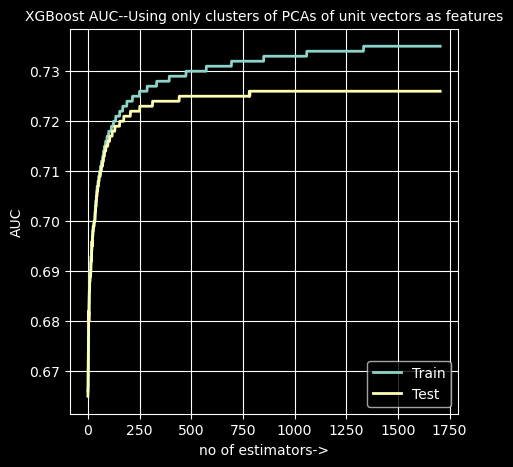

In [ ]:
# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);

### Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [ ]:
# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = avazuunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

SyntaxError: invalid syntax (3228214416.py, line 18)

## Analysing Graphs
Deriving features directly from graphs


In [ ]:
# 21.0 Path where .gml files are placed:

pathToFolder = avazugraphs
filelist = sorted(list(pathToFolder.iterdir()))
filelist[5:10]   # mgrid_bigraph_*


[WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cfourteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cnineteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cone.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cseventeen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Csixteen.gml')]

### Read back data files

In [ ]:
# 21.1 Just to recapitulate:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [ ]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)
y_train.shape       #
test_trans.shape    # (499831, 591)
y_test.shape        #

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_id', 'device_id']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1499493, 576)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

#
gc.collect()

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,1624,104,4,3356,1,...,0.086143,0.694915,0.141788,0.016860,0.508475,0.175684,0.022399,0.966102,0.144482,0.020157
1,1005,0,1610,2741,5,2110,30,4,4138,1,...,-0.005279,0.711864,0.142679,0.017328,0.288136,0.084613,0.015599,0.847458,0.137510,0.017518


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,2198,209,4,1012,1,...,0.074523,1.000000,0.165342,0.024729,0.796610,0.206639,0.037151,0.847458,0.136972,0.017598
1,1005,1,271,192,22,3617,110,0,4213,1,...,-0.027320,0.694915,0.141788,0.016860,0.050847,0.010373,0.005809,0.881356,0.139722,0.018241


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,1624,104,4,19447,744774,...,50,2507,0,35,-1,157,10,2,22,13
1,1005,0,1610,2741,5,2110,30,4,268552,187878,...,50,2681,1,419,100084,212,10,3,30,8


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,2198,209,4,184577,264759,...,50,1996,1,41,100057,71,10,3,23,13
1,1005,1,271,192,22,3617,110,0,184577,65793,...,50,2371,0,559,100217,46,10,1,28,23


(1499493, 591)

(1499493,)

(499831, 591)

(499831,)

(1499493, 576)

(499831, 576)

CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath=WindowsPath('D:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('D:/avazu/allmodels'),
                  saveGraph=True)

0

In [ ]:
# 22.0 Get sample list of projected and bigraphs:

projected = [str(i).split("\\")[-1] for i in filelist if 'appcategory_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'appcategory_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['appcategory_bigraph_Cone.gml',
 'appcategory_bigraph_appid.gml',
 'appcategory_bigraph_siteid.gml',
 'appcategory_bigraph_Ctwenty.gml',
 'appcategory_bigraph_Cfifteen.gml',
 'appcategory_bigraph_Csixteen.gml',
 'appcategory_bigraph_appdomain.gml',
 'appcategory_bigraph_bannerpos.gml']



====



['appcategory_projected_Cone.gml',
 'appcategory_projected_appid.gml',
 'appcategory_projected_siteid.gml',
 'appcategory_projected_Ctwenty.gml',
 'appcategory_projected_Cfifteen.gml',
 'appcategory_projected_Csixteen.gml',
 'appcategory_projected_appdomain.gml',
 'appcategory_projected_bannerpos.gml']

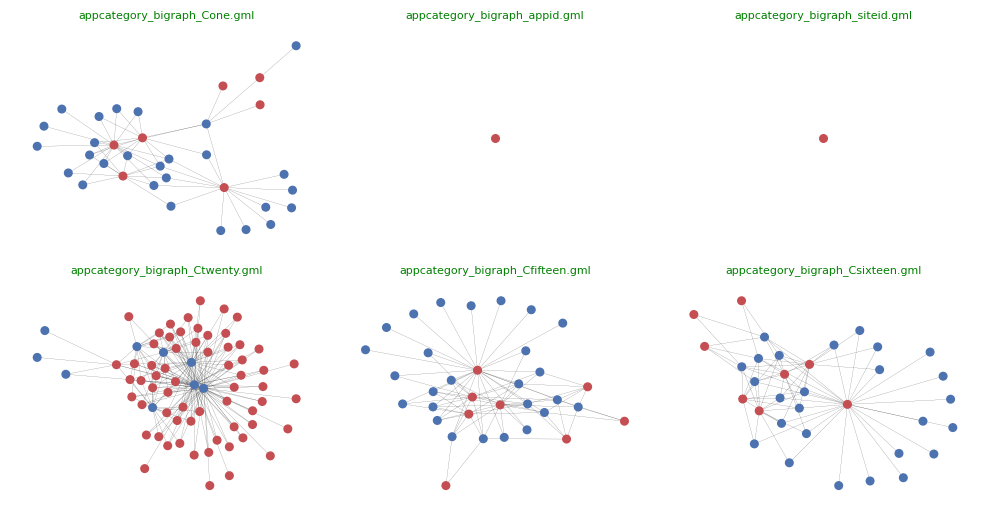

In [ ]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 avazugraphs,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

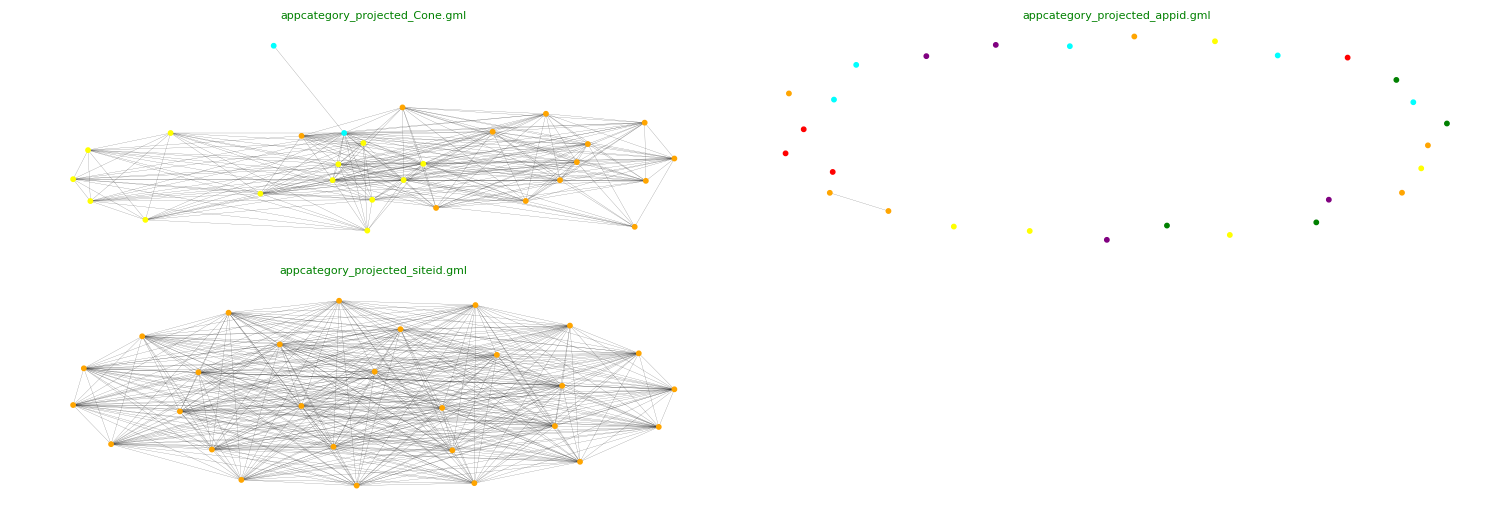

In [ ]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   avazugraphs,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [ ]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
#pathToGraphFolder= Path("D:\\avazu\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  siteid_projected_Cone.gml
Reading file:  siteid_projected_bannerpos.gml
Reading file:  siteid_projected_sitedomain.gml
Reading file:  siteid_projected_sitecategory.gml
Reading file:  siteid_projected_appid.gml
Reading file:  siteid_projected_appdomain.gml
Reading file:  siteid_projected_appcategory.gml
Reading file:  siteid_projected_devicemodel.gml
Reading file:  siteid_projected_devicetype.gml
Reading file:  siteid_projected_deviceconntype.gml
Reading file:  siteid_projected_Cfourteen.gml
Reading file:  siteid_projected_Cfifteen.gml
Reading file:  siteid_projected_Csixteen.gml
Reading file:  siteid_projected_Cseventeen.gml
Reading file:  siteid_projected_Ceighteen.gml
Reading file:  siteid_projected_Cnineteen.gml
Reading file:  siteid_projected_Ctwenty.gml
Reading file:  siteid_projected_Ctwentyone.gml
Reading file:  sitedomain_projected_Cone.gml
Reading file:  sitedomain_projected_bannerpos.gml
Reading file:  sitedomain_projected_siteid

In [ ]:
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (1501119, 212)/(1499493, 212)
print("\n--\n")
fg_te[0].shape   # (500374, 212)/(499831, 212)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(1499493, 212)


--



(499831, 212)


--



,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,1,0,0,0,0,1,0,0
1,1.0,1.0,1110.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,1,0,0,0,0,0,0


In [ ]:
# 24.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (1499493, 212)
Datashape after processing: (1499493, 161)


In [ ]:
# 24.2 Save the list to gdrive:

utils.savePythonObject(fg_tr, "fg_tr.pkl", avazudata)
utils.savePythonObject(fg_te, "fg_te.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\fg_tr.pkl
Object saved to: D:\avazu\allmodels\datafiles\fg_te.pkl


In [ ]:
# 24.3

fg_tr = utils.restorePythonObject( "fg_tr.pkl", avazudata )
fg_te = utils.restorePythonObject( "fg_te.pkl", avazudata )
fg_tr[0].shape  # (1501119, 161)/(1499493, 161)
fg_te[0].shape  # (500374, 161)/(499831, 161)

(1499493, 161)

(499831, 161)

In [ ]:
# 24.4 Check restoration:

fg_tr[0].head(2)
fg_te[0].head(2)

,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0,0,1,0,1,0,0,1,0,0
1,1.0,1.0,1110.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,0,1,1,0,0,0,0


## xgboost modeling with data transformed through community classes

In [ ]:
# 25.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 13,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 50,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[13:05:34] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[13:05:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4044 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73636	validation_1-auc:0.73064
[13:05:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3798 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73914	validation_1-auc:0.73256
[13:05:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3880 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.74059	validation_1-auc:0.73384
[13:05:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3830 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.74183	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# Save model object:

utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_trans_commu.pkl


In [ ]:
# Restore model object:

model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", avazudata)

### Learning curve

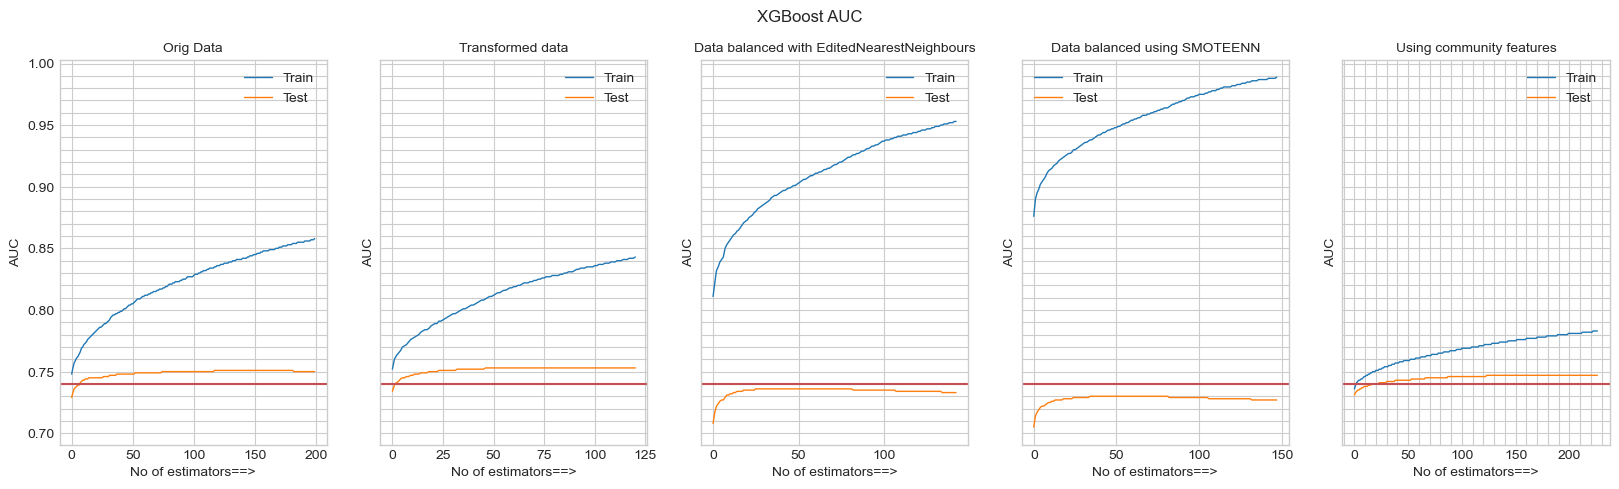

In [ ]:
# 19.3 Learning curves: xgboost modeling"

plt.style.use('seaborn-v0_8-whitegrid')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,5, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result(), model_trans_commu.evals_result()]
title = ["Orig Data", "Transformed data", "Data balanced with EditedNearestNeighbours", 'Data balanced using SMOTEENN',"Using community features" ]
fig.suptitle("XGBoost AUC")
for i in range(5):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 10);
    ax[i].axhline(y=0.74, color='r', linestyle='-')

plt.show();

#### Classification report

In [ ]:
# 25.2 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")


Classification report from community data: 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.60      0.08      0.15     84744

    accuracy                           0.84    499831
   macro avg       0.72      0.54      0.53    499831
weighted avg       0.80      0.84      0.78    499831



In [ ]:
############# Done ###############

## ROUGH WORK

In [ ]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1501119, 599)
y_train.shape       # (1501119,)
test_trans.shape    # (500374, 599)
y_test.shape        # (500374,)

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'device_id',  'device_ip']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1501119, 586)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazufolder)
ct

#
gc.collect()

In [ ]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazufolder) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazufolder) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.849631,-0.462719,0.560084,0.103338,-0.274097,-0.368581,-0.839830,0.391659,-0.459640,0.165295,...,-0.235170,0.191174,0.061168,1.091684,-0.014206,0.195178,-0.525828,0.365271,-0.450755,0.633413
1,1.155139,0.278564,0.410264,-1.244982,0.711136,2.161509,1.152552,-0.602603,1.328864,-1.608991,...,7.061366,-0.712683,0.027135,-0.952509,3.091211,1.870719,-0.473455,-3.947109,3.381505,1.684289
2,-0.679183,-0.699284,-0.083493,0.025313,-0.233486,0.085268,-0.849323,0.032845,-0.439538,0.117099,...,0.224154,-0.034428,0.339811,0.868301,-0.223116,-1.030807,-0.455839,0.140223,-0.364641,0.703816


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.771130,-0.453043,0.095163,0.557658,-0.344208,-0.033671,-0.710520,0.435808,-0.115957,1.102022,...,0.177579,-0.462857,-0.303582,-0.536073,-0.035448,-0.485754,-0.589400,0.886848,-0.017880,-0.268141
1,-0.752837,-0.339575,0.088783,-1.141025,-0.199802,0.185162,0.043599,0.124799,-1.227015,0.896823,...,-0.518168,-0.111798,0.725304,-0.462391,-0.174001,-0.462952,1.012376,-1.013665,-0.281133,-0.180926
2,-0.827908,-0.954810,-0.000639,-0.099604,0.415293,-0.110808,0.136972,-0.378553,-1.093366,0.855857,...,-0.710794,0.551108,0.100063,0.058558,-0.215256,-0.200750,0.266654,-0.267910,0.074544,0.263067


In [ ]:
from imblearn.under_sampling import InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, NeighbourhoodCleaningRule,OneSidedSelection
from imblearn.combine import SMOTEENN

In [ ]:
inst = InstanceHardnessThreshold()
start = time.time()
X_res, y_res = inst.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


In [ ]:
X_res.shape  # (548699, 97)
y_res.shape  # (548699,)

(548699, 97)

(548699,)

In [ ]:

model_km = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res
test_X =  pca_test
ytrain =  y_res
ytest = y_test


model_km.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[15:00:36] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:00:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3780 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.93528	validation_1-auc:0.69267
[15:00:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3834 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.94281	validation_1-auc:0.69800
[15:00:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3868 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.94824	validation_1-auc:0.70308
[15:00:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4184 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.95010	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 24.3 Classification report:

pred_km = model_km.predict(test_X)
print(classification_report(ytest,pred_km))


              precision    recall  f1-score   support

           0       0.94      0.41      0.58    414878
           1       0.23      0.88      0.37     84806

    accuracy                           0.49    499684
   macro avg       0.59      0.65      0.47    499684
weighted avg       0.82      0.49      0.54    499684



In [ ]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_km.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(y_test, pred_km, labels=model_km.classes_)

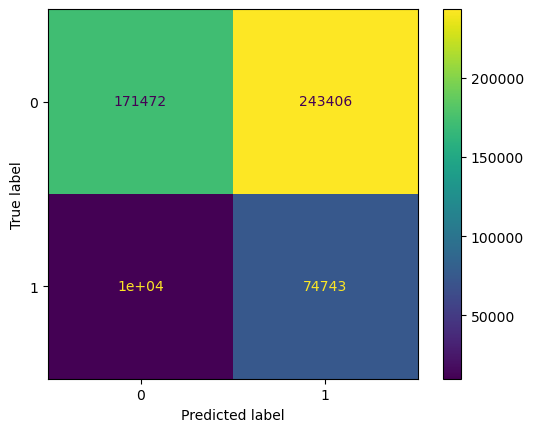

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_km.classes_)
disp.plot()

In [ ]:
ncr = NeighbourhoodCleaningRule()
start = time.time()
X_res_ncr, y_res_ncr = ncr.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


35.54191811879476


In [ ]:
X_res_ncr.shape  # (1086165, 97)
y_res_ncr.shape  # (1086165, )

(1086165, 97)

(1086165,)

In [ ]:

model_ncr = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res_ncr
test_X =  pca_test
ytrain =  y_res_ncr
ytest = y_test


model_ncr.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[05:24:44] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[05:24:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4136 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.78990	validation_1-auc:0.70346
[05:24:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3772 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.80119	validation_1-auc:0.71216
[05:24:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4058 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.80691	validation_1-auc:0.71571
[05:25:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4020 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.81086	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_ncr.best_score  # 0.73726971

0.7372697120689804

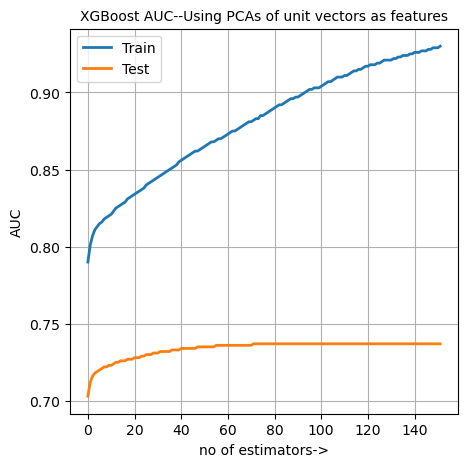

In [ ]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_ncr.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [ ]:
# 24.3 Classification report:

pred_ncr = model_ncr.predict(test_X)
print(classification_report(ytest,pred_ncr))


              precision    recall  f1-score   support

           0       0.87      0.88      0.87    414878
           1       0.37      0.35      0.36     84806

    accuracy                           0.79    499684
   macro avg       0.62      0.61      0.62    499684
weighted avg       0.78      0.79      0.79    499684



In [ ]:
####################